<center><p float="center">
 
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=10>Feature Engineering and Model Tuning</center></font></h1>
<h1><center> ReneWind Project Debrief</center></h1>

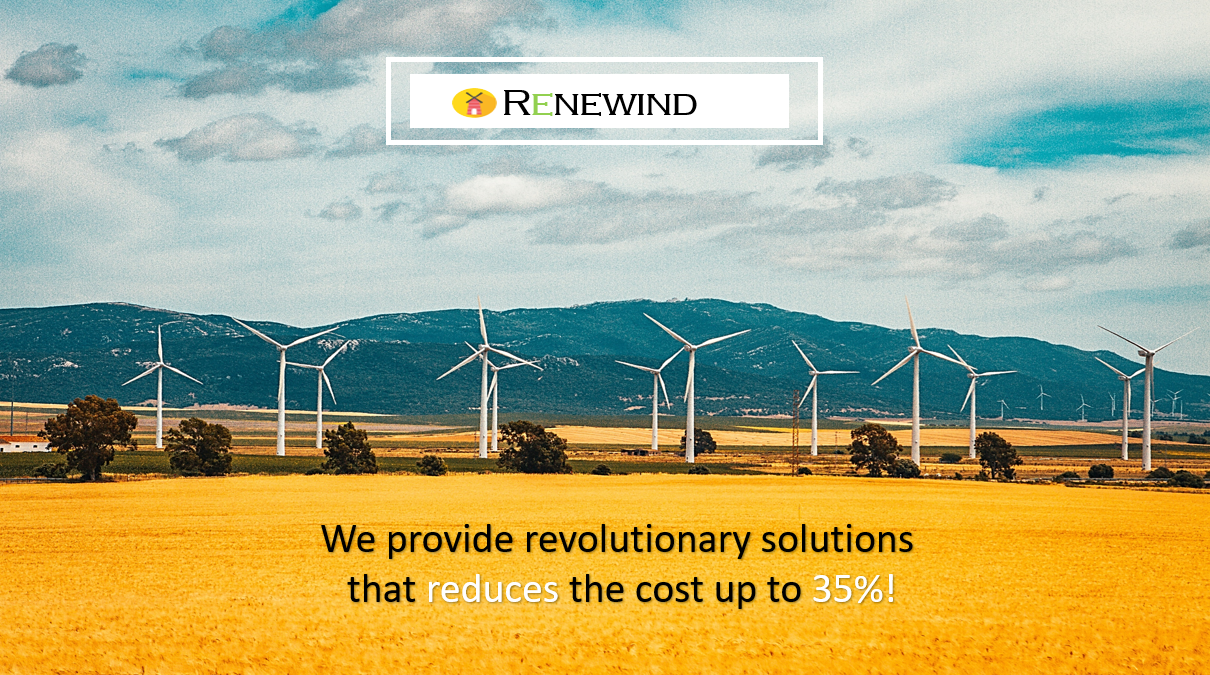

<b><h2><center> ReneWind Project </center></h2></b>

## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



### Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

### Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Note: This is a sample solution for the project. Projects will NOT be graded on the basis of how well the submission matches this sample solution. Projects will be graded on the basis of the rubric only.

## Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

## Loading the dataset

In [2]:
df = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

## Data Overview

The initial steps to get an overview of any dataset is to: 
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

### Checking the shape of the dataset

In [3]:
# Checking the number of rows and columns in the training data
df.shape

(20000, 41)

* The training dataset has 20000 rows and 41 columns 

In [4]:
# Checking the number of rows and columns in the test data
df_test.shape

(5000, 41)

* The test dataset has 5000 rows and 41 columns 

In [5]:
# let's create a copy of the training data
data = df.copy()

In [6]:
# let's create a copy of the training data
data_test = df_test.copy()

### Displaying the first few rows of the dataset

In [7]:
# let's view the first 5 rows of the data
data.head()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
0 -4.465 -4.679  3.102  0.506 -0.221 -2.033 -2.911  0.051 -1.522  3.762   
1  3.366  3.653  0.910 -1.368  0.332  2.359  0.733 -4.332  0.566 -0.101   
2 -3.832 -5.824  0.634 -2.419 -1.774  1.017 -2.099 -3.173 -2.082  5.393   
3  1.618  1.888  7.046 -1.147  0.083 -1.530  0.207 -2.494  0.345  2.119   
4 -0.111  3.872 -3.758 -2.983  3.793  0.545  0.205  4.849 -1.855 -6.220   

     V11    V12    V13    V14    V15    V16    V17    V18    V19    V20  \
0 -5.715  0.736  0.981  1.418 -3.376 -3.047  0.306  2.914  2.270  4.395   
1  1.914 -0.951 -1.255 -2.707  0.193 -4.769 -2.205  0.908  0.757 -5.834   
2 -0.771  1.107  1.144  0.943 -3.164 -4.248 -4.039  3.689  3.311  1.059   
3 -3.053  0.460  2.705 -0.636 -0.454 -3.174 -3.404 -1.282  1.582 -1.952   
4  1.998  4.724  0.709 -1.989 -2.633  4.184  2.245  3.734 -6.313 -5.380   

     V21    V22    V23    V24    V25    V26    V27    V28    V29    V30  \
0 -2.388  0.646 -1.191  3.133  0.665 -2.511 -0.037  0.726 -3.982 -1.073   
1 -3.065  1.597 -1.757  1.766 -0.267  3.625  1.500 -0.586  0.783 -0.201   
2 -2.143  1.650 -1.661  1.680 -0.451 -4.551  3.739  1.134 -2.034  0.841   
3 -3.517 -1.206 -5.628 -1.818  2.124  5.295  4.748 -2.309 -3.963 -6.029   
4 -0.887  2.062  9.446  4.490 -3.945  4.582 -8.780 -3.383  5.107  6.788   

     V31    V32    V33     V34   V35    V36    V37    V38    V39    V40  \
0  1.667  3.060 -1.690   2.846 2.235  6.667  0.444 -2.369  2.951 -3.480   
1  0.025 -1.795  3.033  -2.468 1.895 -2.298 -1.731  5.909 -0.386  0.616   
2 -1.600 -0.257  0.804   4.086 2.292  5.361  0.352  2.940  3.839 -4.309   
3  4.949 -3.584 -2.577   1.364 0.623  5.550 -1.527  0.139  3.101 -1.277   
4  2.044  8.266  6.629 -10.069 1.223 -3.230  1.687 -2.164 -3.645  6.510   

   Target  
0       0  
1       0  
2       0  
3       0  
4       0

### Displaying the first few rows of the dataset

In [8]:
# let's view the last 5 rows of the data
data.tail()

V1      V2     V3     V4     V5     V6     V7     V8     V9    V10  \
19995 -2.071  -1.088 -0.796 -3.012 -2.288  2.807  0.481  0.105 -0.587 -2.899   
19996  2.890   2.483  5.644  0.937 -1.381  0.412 -1.593 -5.762  2.150  0.272   
19997 -3.897  -3.942 -0.351 -2.417  1.108 -1.528 -3.520  2.055 -0.234 -0.358   
19998 -3.187 -10.052  5.696 -4.370 -5.355 -1.873 -3.947  0.679 -2.389  5.457   
19999 -2.687   1.961  6.137  2.600  2.657 -4.291 -2.344  0.974 -1.027  0.497   

         V11    V12   V13    V14    V15     V16    V17    V18    V19    V20  \
19995  8.868  1.717 1.358 -1.777  0.710   4.945 -3.100 -1.199 -1.085 -0.365   
19996 -2.095 -1.526 0.072 -3.540 -2.762 -10.632 -0.495  1.720  3.872 -1.210   
19997 -3.782  2.180 6.112  1.985 -8.330  -1.639 -0.915  5.672 -3.924  2.133   
19998  1.583  3.571 9.227  2.554 -7.039  -0.994 -9.665  1.155  3.877  3.524   
19999 -9.589  3.177 1.055 -1.416 -4.669  -5.405  3.720  2.893  2.329  1.458   

         V21    V22    V23    V24    V25    V26    V27    V28    V29    V30  \
19995  3.131 -3.948 -3.578 -8.139 -1.937 -1.328 -0.403 -1.735  9.996  6.955   
19996 -8.222  2.121 -5.492  1.452  1.450  3.685  1.077 -0.384 -0.839 -0.748   
19997 -4.502  2.777  5.728  1.620 -1.700 -0.042 -2.923 -2.760 -2.254  2.552   
19998 -7.015 -0.132 -3.446 -4.801 -0.876 -3.812  5.422 -3.732  0.609  5.256   
19999 -6.429  1.818  0.806  7.786  0.331  5.257 -4.867 -0.819 -5.667 -2.861   

         V31    V32    V33    V34    V35    V36    V37    V38   V39    V40  \
19995 -3.938 -8.274  5.745  0.589 -0.650 -3.043  2.216  0.609 0.178  2.928   
19996 -1.089 -4.159  1.181 -0.742  5.369 -0.693 -1.669  3.660 0.820 -1.987   
19997  0.982  7.112  1.476 -3.954  1.856  5.029  2.083 -6.409 1.477 -0.874   
19998  1.915  0.403  3.164  3.752  8.530  8.451  0.204 -7.130 4.249 -6.112   
19999  4.674  6.621 -1.989 -1.349  3.952  5.450 -0.455 -2.202 1.678 -1.974   

       Target  
19995       1  
19996       0  
19997       0  
19998       0  
19999       0

### Checking the data types of the columns for the dataset

In [9]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

- All the variables in the data are of type float

### Checking for duplicate values

In [10]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

- No duplicate values present in the data.

### Checking for missing values

In [11]:
# let's check for missing values in the data
round(data.isnull().sum() / data.isnull().count() * 100, 2)

V1       0.090
V2       0.090
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

- There are 0.090% missing values in V1 and 0.090% missing values in V2

In [12]:
# let's check for missing values in the test data
round(data_test.isnull().sum() / data_test.isnull().count() * 100, 2)

V1       0.100
V2       0.120
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

- There are 0.1% missing values in V1 and 0.12% missing values in V2

### Statistical summary of the dataset

In [13]:
# let's view the statistical summary of the numerical columns in the data
data.describe().T

count   mean   std     min    25%    50%    75%    max
V1     19982.000 -0.272 3.442 -11.876 -2.737 -0.748  1.840 15.493
V2     19982.000  0.440 3.151 -12.320 -1.641  0.472  2.544 13.089
V3     20000.000  2.485 3.389 -10.708  0.207  2.256  4.566 17.091
V4     20000.000 -0.083 3.432 -15.082 -2.348 -0.135  2.131 13.236
V5     20000.000 -0.054 2.105  -8.603 -1.536 -0.102  1.340  8.134
V6     20000.000 -0.995 2.041 -10.227 -2.347 -1.001  0.380  6.976
V7     20000.000 -0.879 1.762  -7.950 -2.031 -0.917  0.224  8.006
V8     20000.000 -0.548 3.296 -15.658 -2.643 -0.389  1.723 11.679
V9     20000.000 -0.017 2.161  -8.596 -1.495 -0.068  1.409  8.138
V10    20000.000 -0.013 2.193  -9.854 -1.411  0.101  1.477  8.108
V11    20000.000 -1.895 3.124 -14.832 -3.922 -1.921  0.119 11.826
V12    20000.000  1.605 2.930 -12.948 -0.397  1.508  3.571 15.081
V13    20000.000  1.580 2.875 -13.228 -0.224  1.637  3.460 15.420
V14    20000.000 -0.951 1.790  -7.739 -2.171 -0.957  0.271  5.671
V15    20000.000 -2.415 3.355 -16.417 -4.415 -2.383 -0.359 12.246
V16    20000.000 -2.925 4.222 -20.374 -5.634 -2.683 -0.095 13.583
V17    20000.000 -0.134 3.345 -14.091 -2.216 -0.015  2.069 16.756
V18    20000.000  1.189 2.592 -11.644 -0.404  0.883  2.572 13.180
V19    20000.000  1.182 3.397 -13.492 -1.050  1.279  3.493 13.238
V20    20000.000  0.024 3.669 -13.923 -2.433  0.033  2.512 16.052
V21    20000.000 -3.611 3.568 -17.956 -5.930 -3.533 -1.266 13.840
V22    20000.000  0.952 1.652 -10.122 -0.118  0.975  2.026  7.410
V23    20000.000 -0.366 4.032 -14.866 -3.099 -0.262  2.452 14.459
V24    20000.000  1.134 3.912 -16.387 -1.468  0.969  3.546 17.163
V25    20000.000 -0.002 2.017  -8.228 -1.365  0.025  1.397  8.223
V26    20000.000  1.874 3.435 -11.834 -0.338  1.951  4.130 16.836
V27    20000.000 -0.612 4.369 -14.905 -3.652 -0.885  2.189 17.560
V28    20000.000 -0.883 1.918  -9.269 -2.171 -0.891  0.376  6.528
V29    20000.000 -0.986 2.684 -12.579 -2.787 -1.176  0.630 10.722
V30    20000.000 -0.016 3.005 -14.796 -1.867  0.184  2.036 12.506
V31    20000.000  0.487 3.461 -13.723 -1.818  0.490  2.731 17.255
V32    20000.000  0.304 5.500 -19.877 -3.420  0.052  3.762 23.633
V33    20000.000  0.050 3.575 -16.898 -2.243 -0.066  2.255 16.692
V34    20000.000 -0.463 3.184 -17.985 -2.137 -0.255  1.437 14.358
V35    20000.000  2.230 2.937 -15.350  0.336  2.099  4.064 15.291
V36    20000.000  1.515 3.801 -14.833 -0.944  1.567  3.984 19.330
V37    20000.000  0.011 1.788  -5.478 -1.256 -0.128  1.176  7.467
V38    20000.000 -0.344 3.948 -17.375 -2.988 -0.317  2.279 15.290
V39    20000.000  0.891 1.753  -6.439 -0.272  0.919  2.058  7.760
V40    20000.000 -0.876 3.012 -11.024 -2.940 -0.921  1.120 10.654
Target 20000.000  0.056 0.229   0.000  0.000  0.000  0.000  1.000

#### Observations:
- Values of all the variables lies between -25 and 25
- Looking at the values of 75th percentile and maximum, we can see there are outliers in many variables like V1, V2 and many more.

## Exploratory Data Analysis

### Univariate analysis

In [14]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

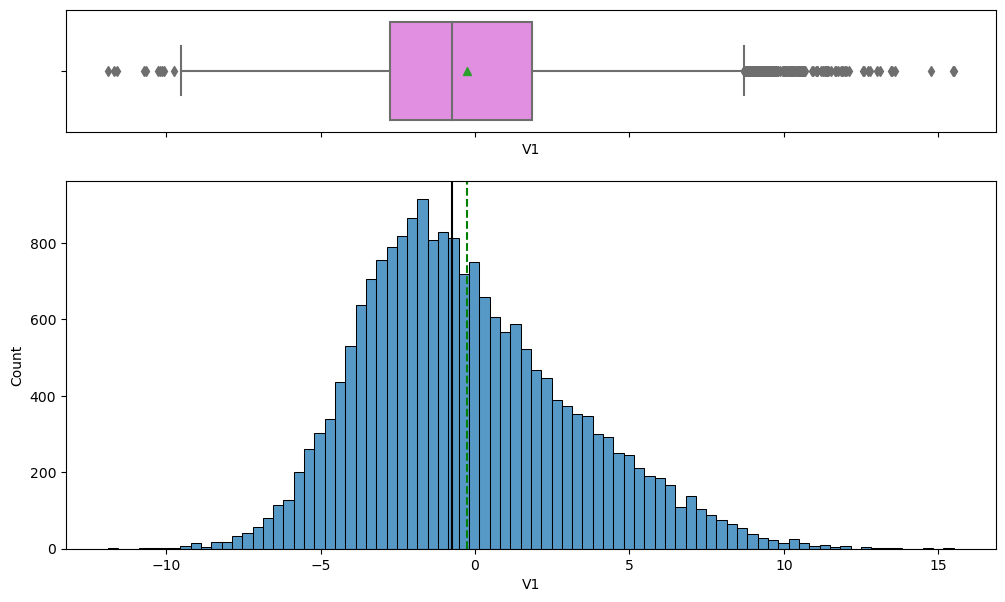

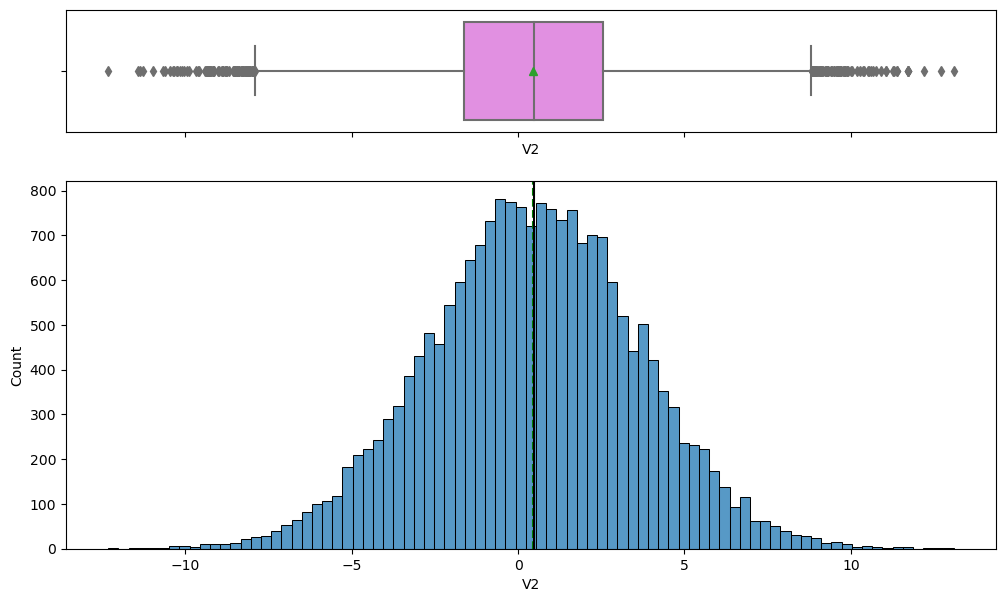

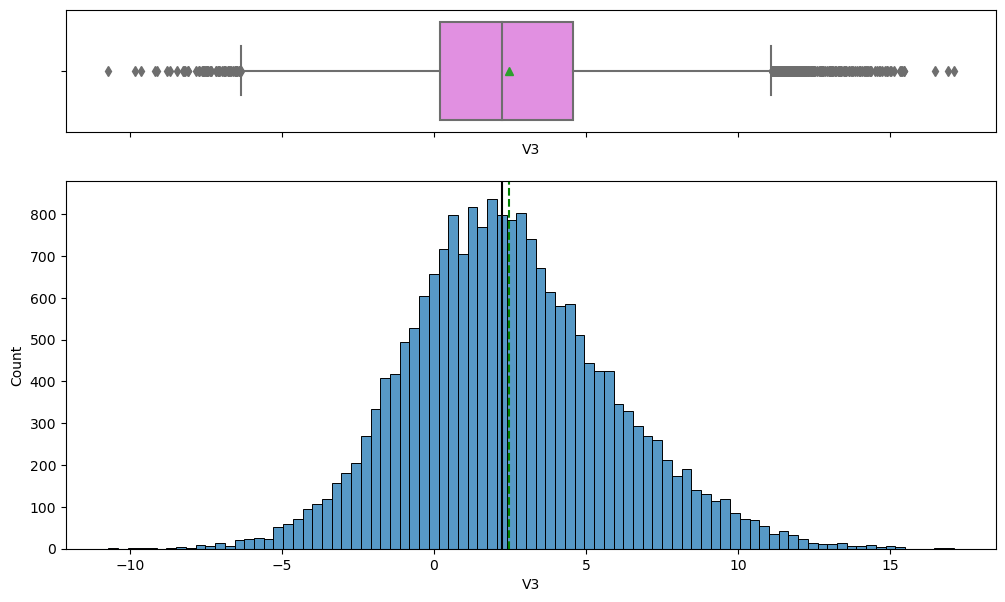

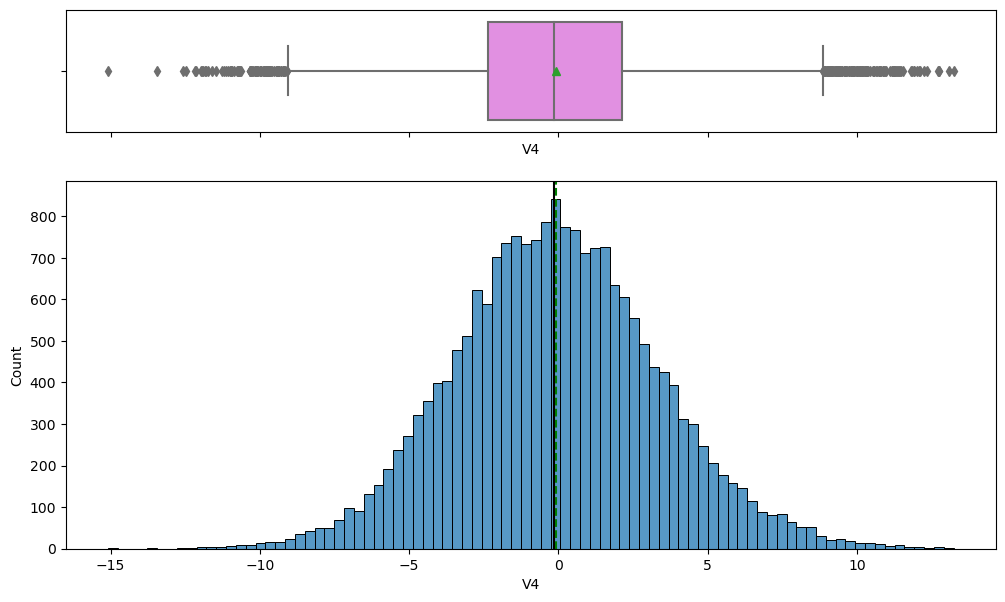

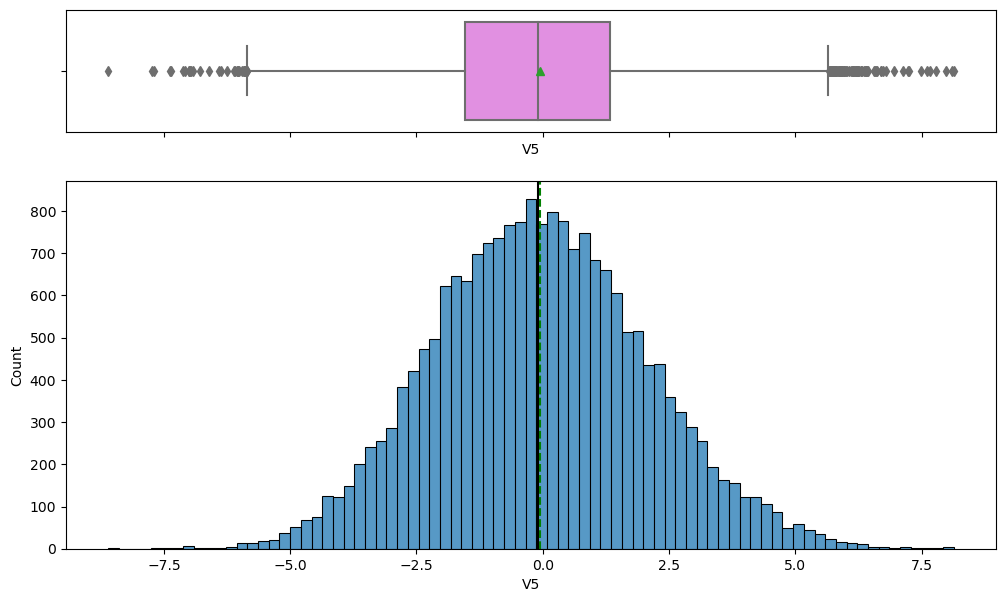

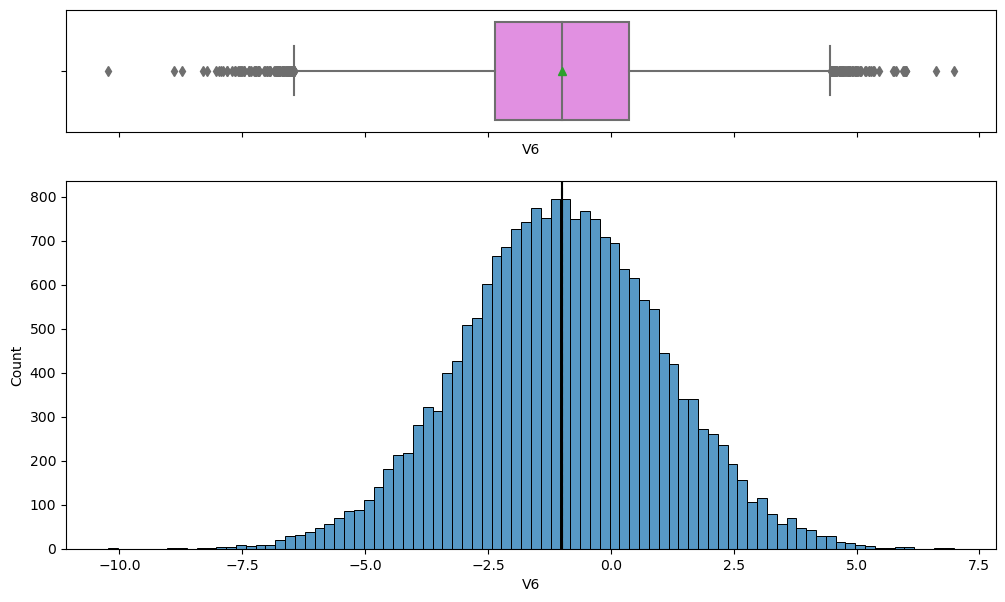

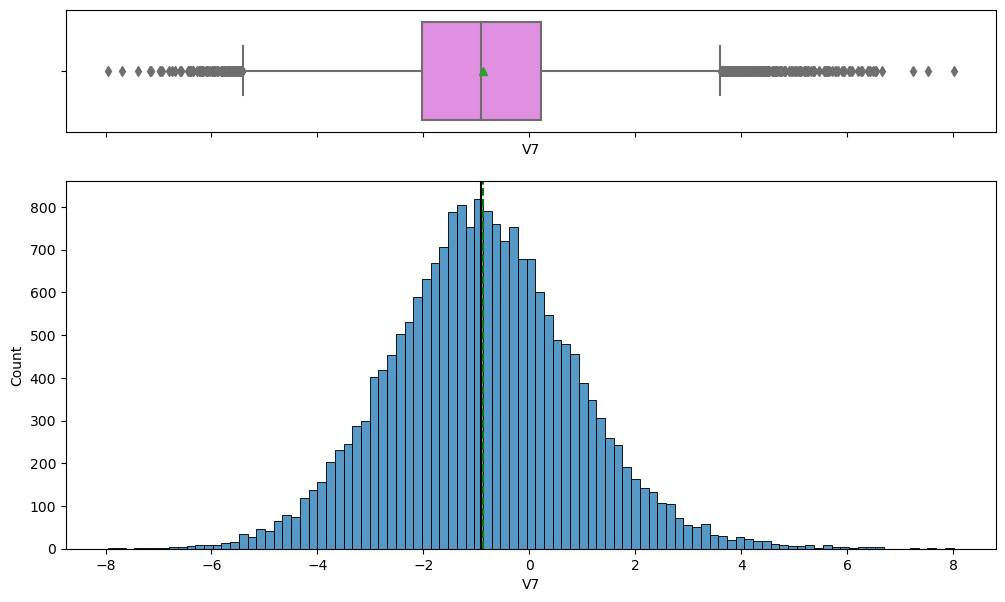

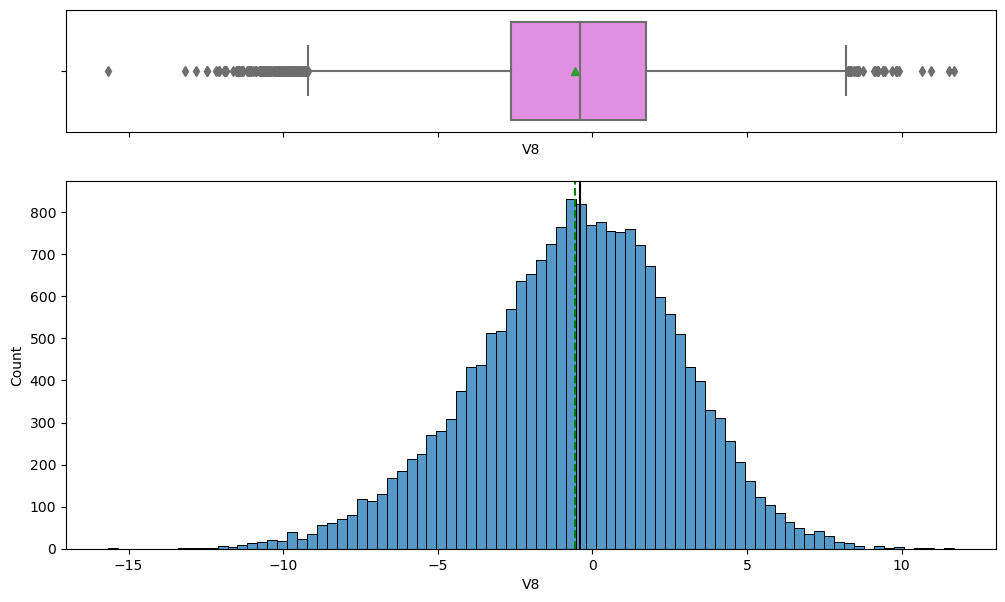

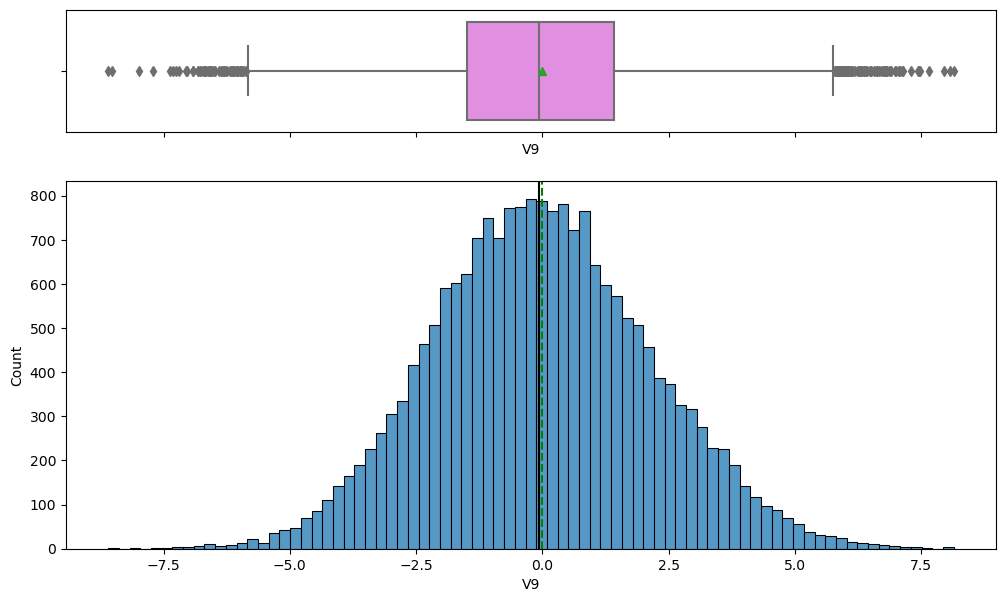

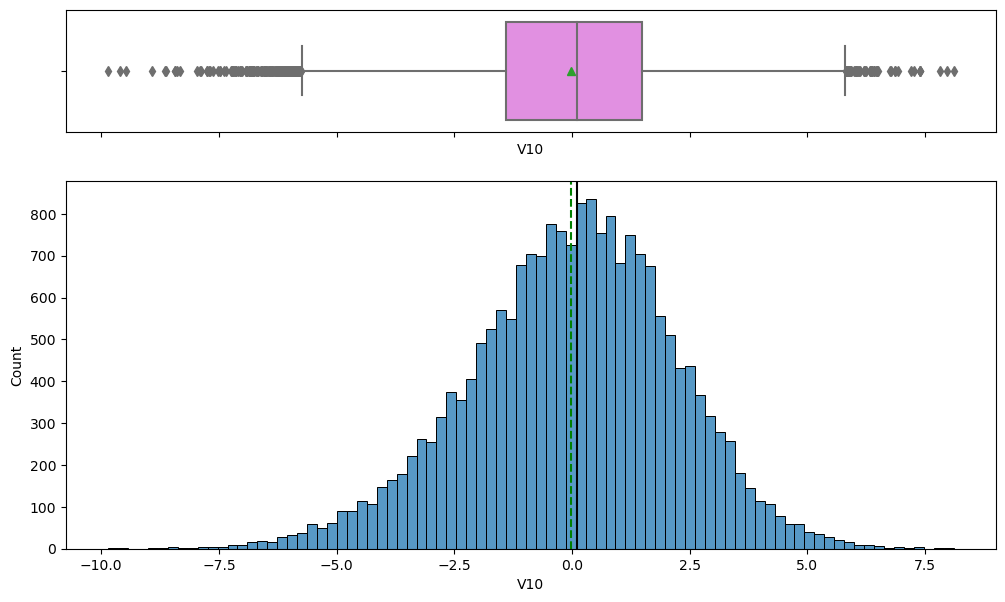

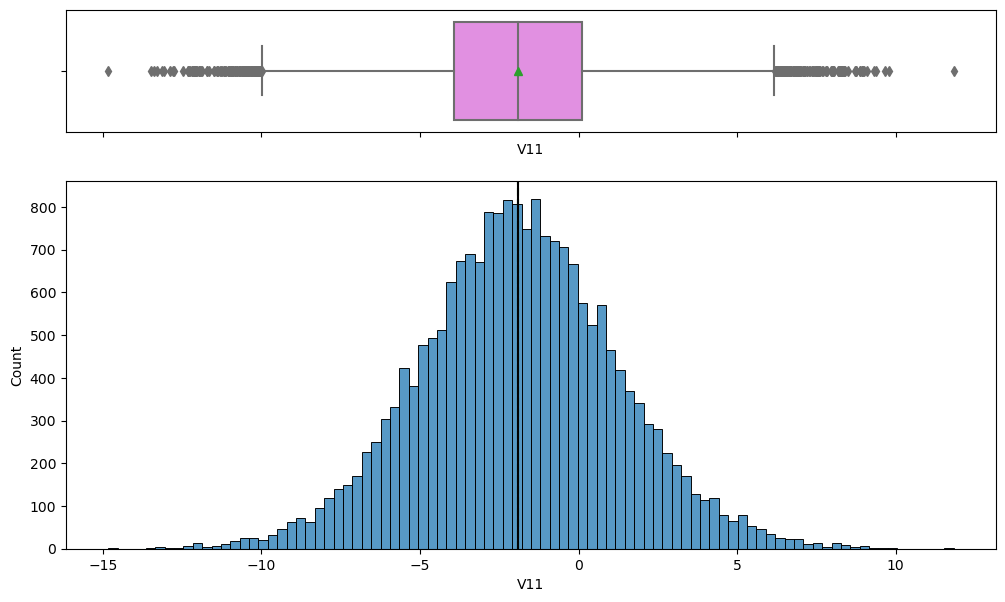

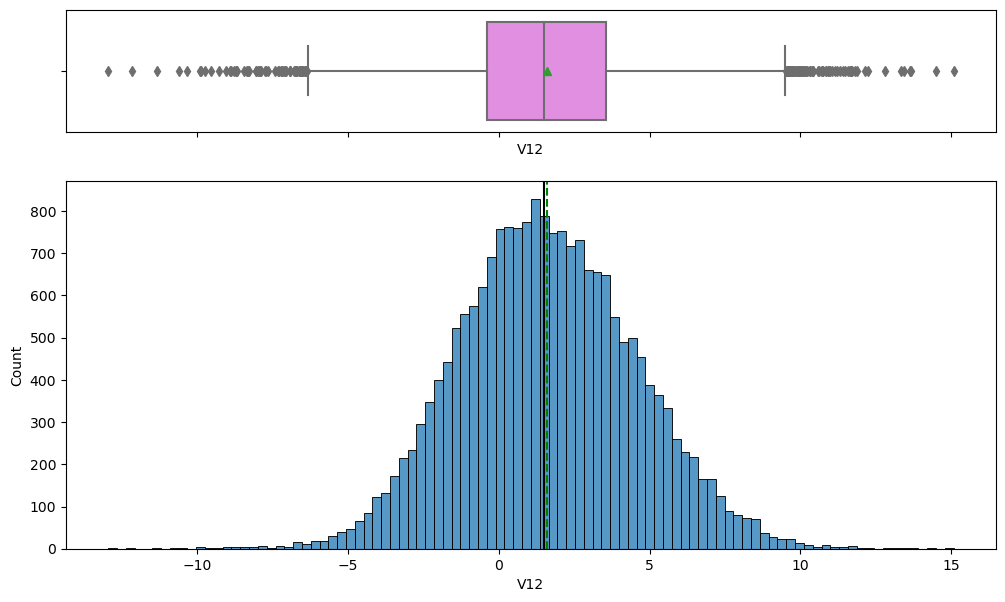

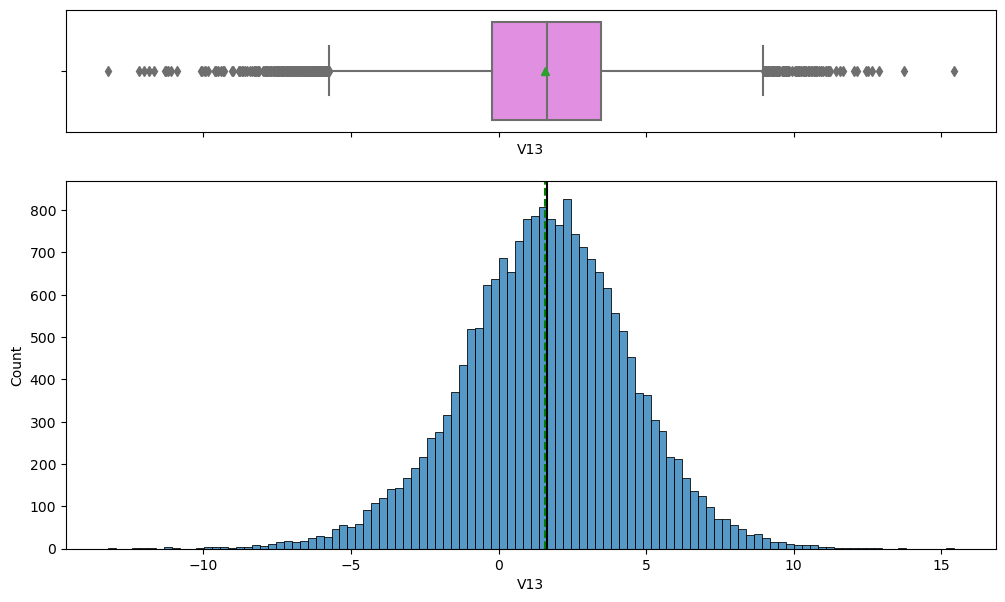

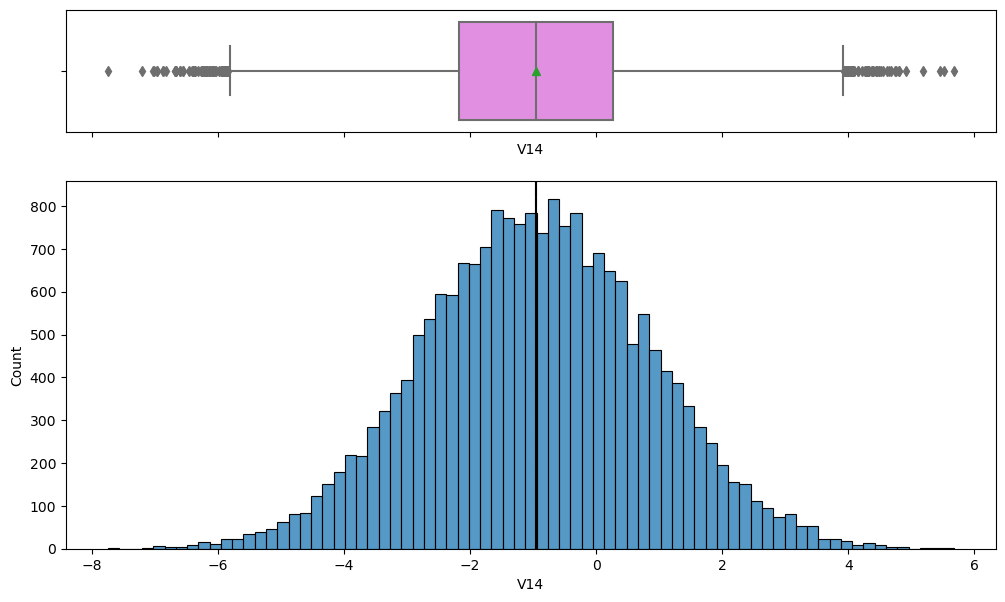

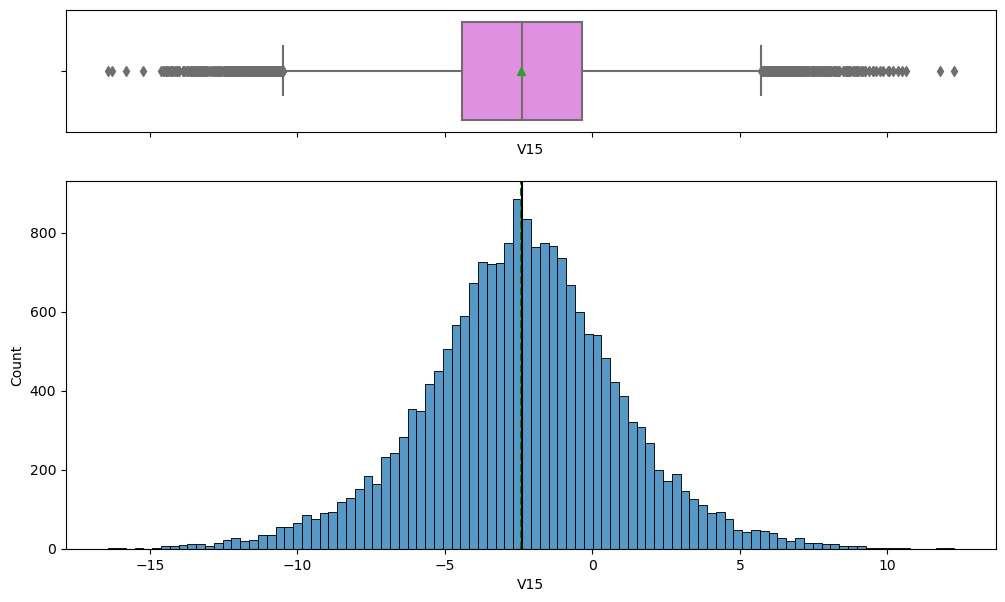

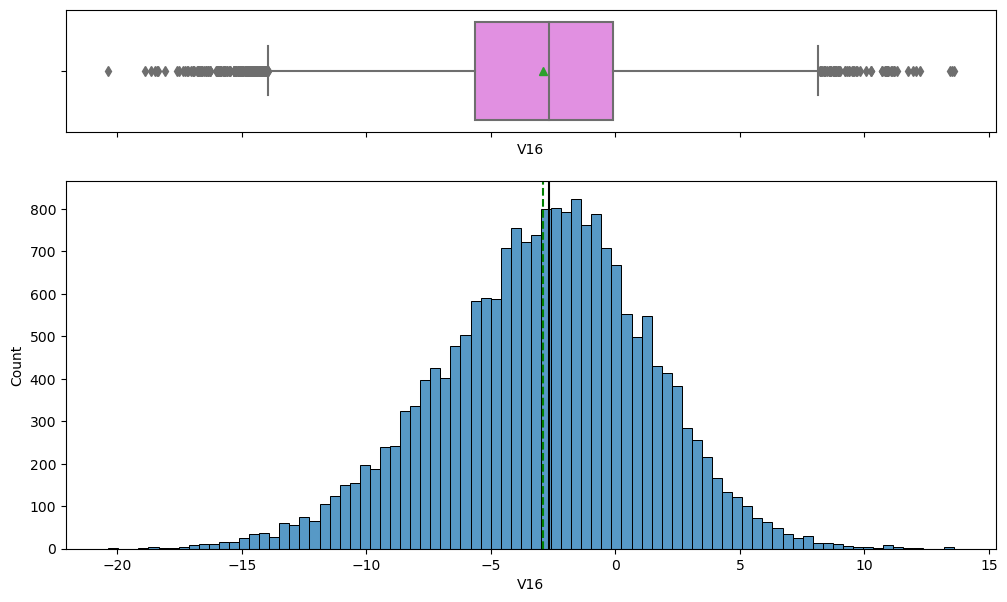

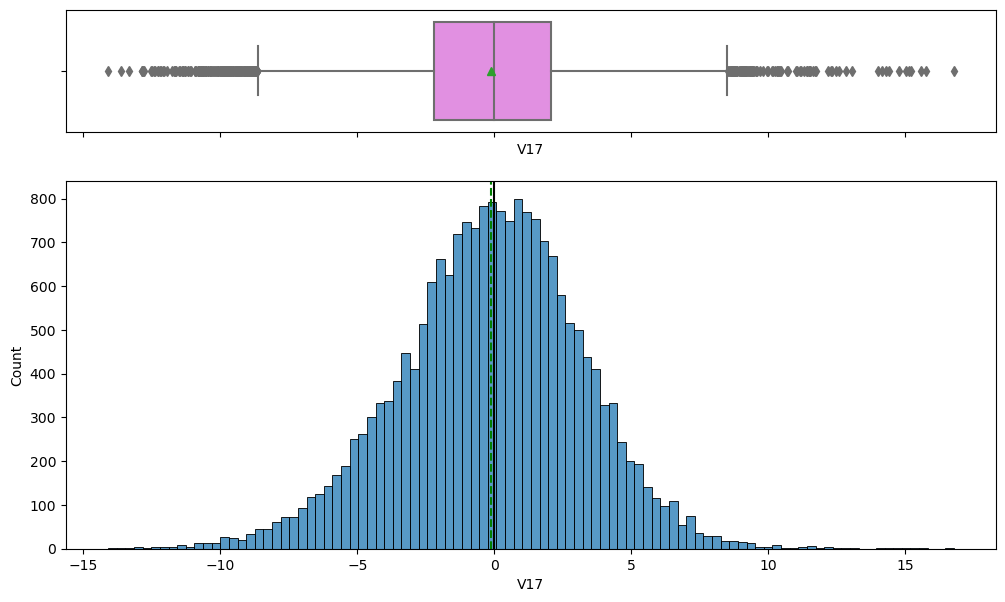

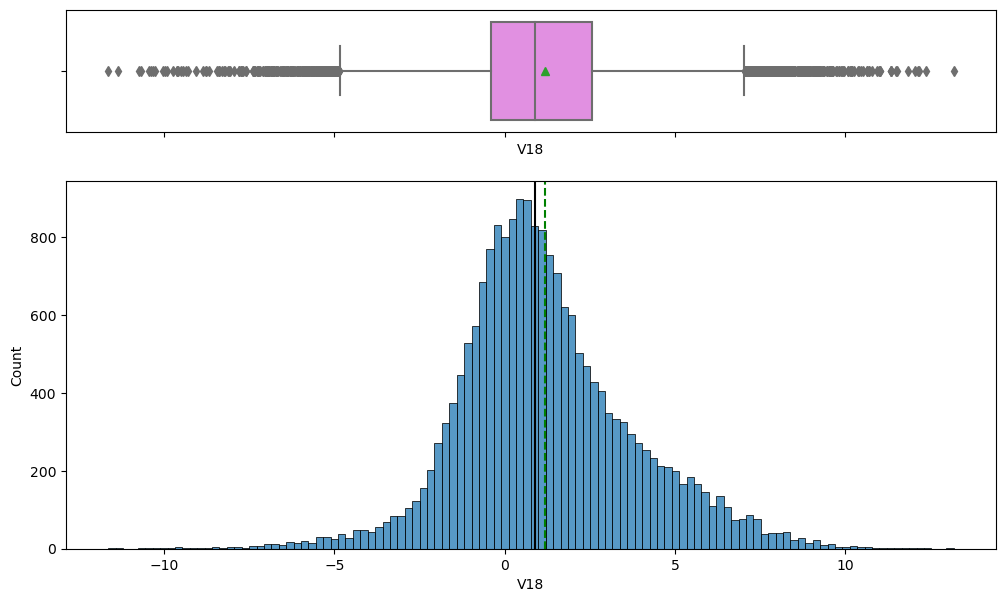

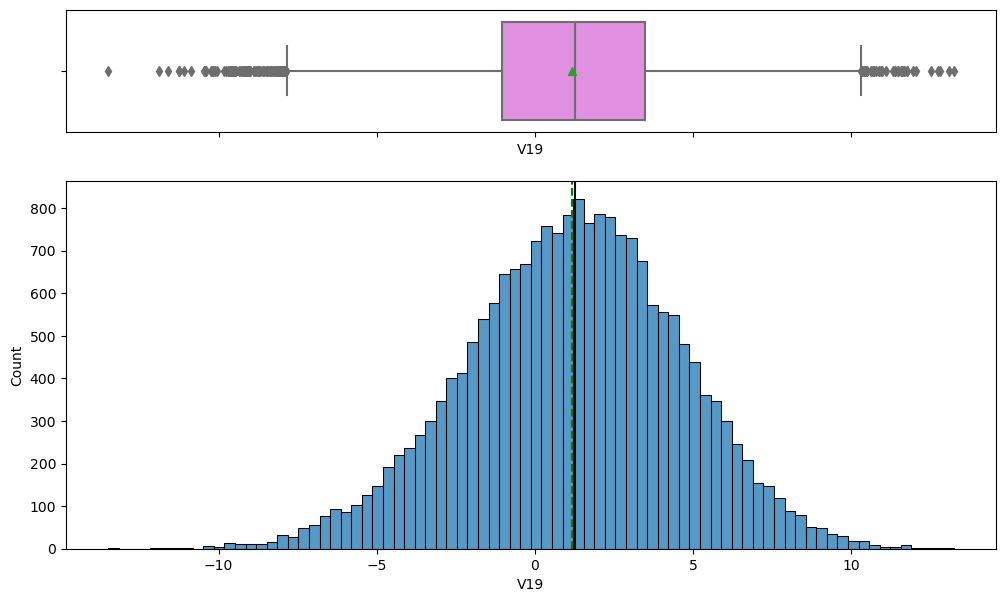

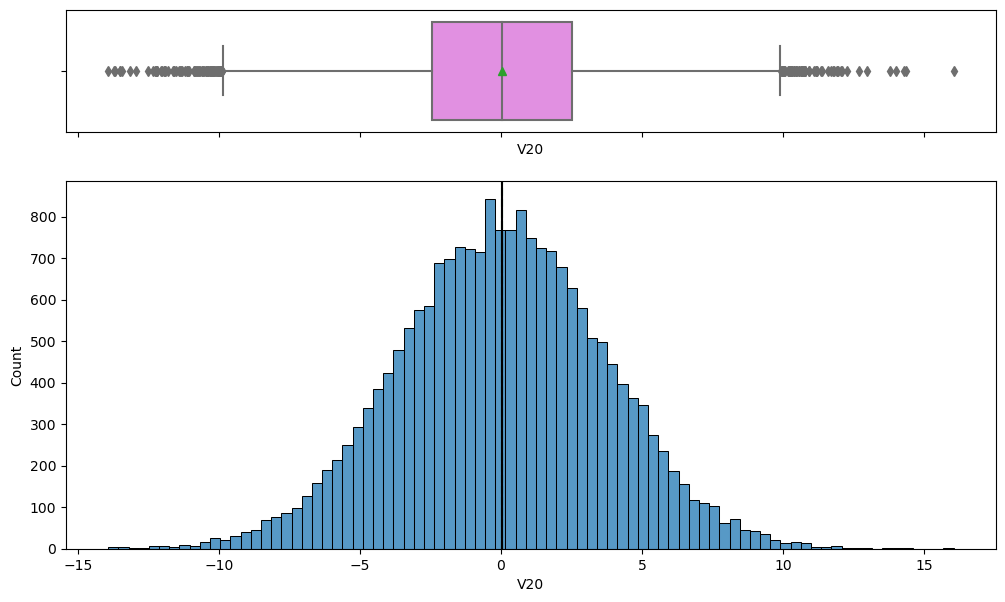

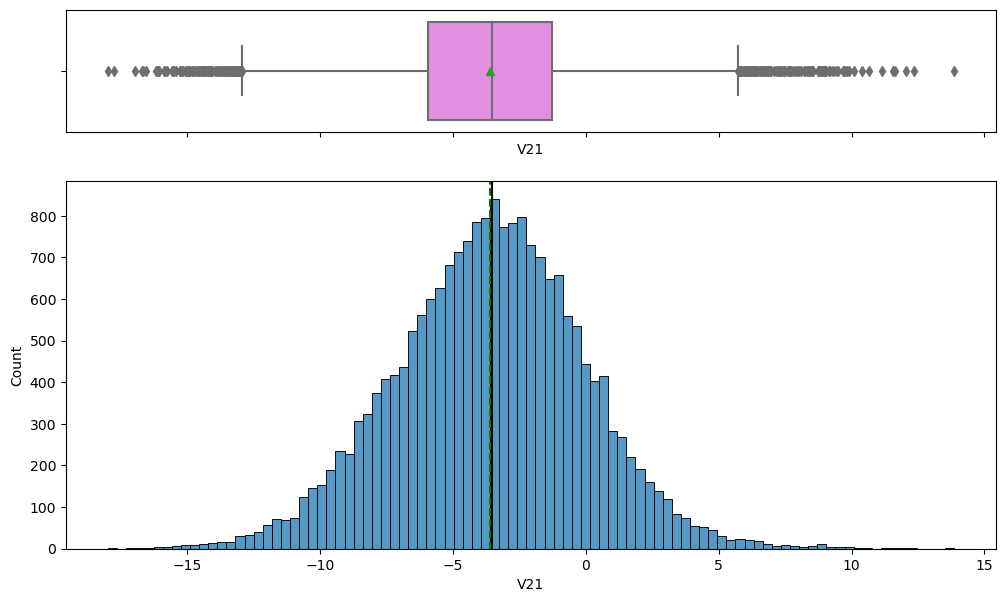

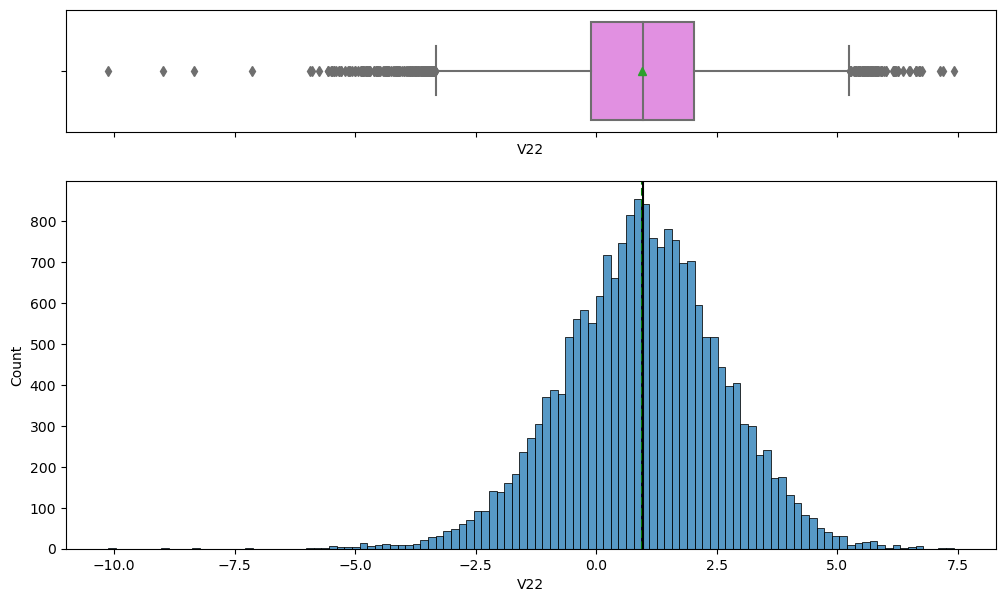

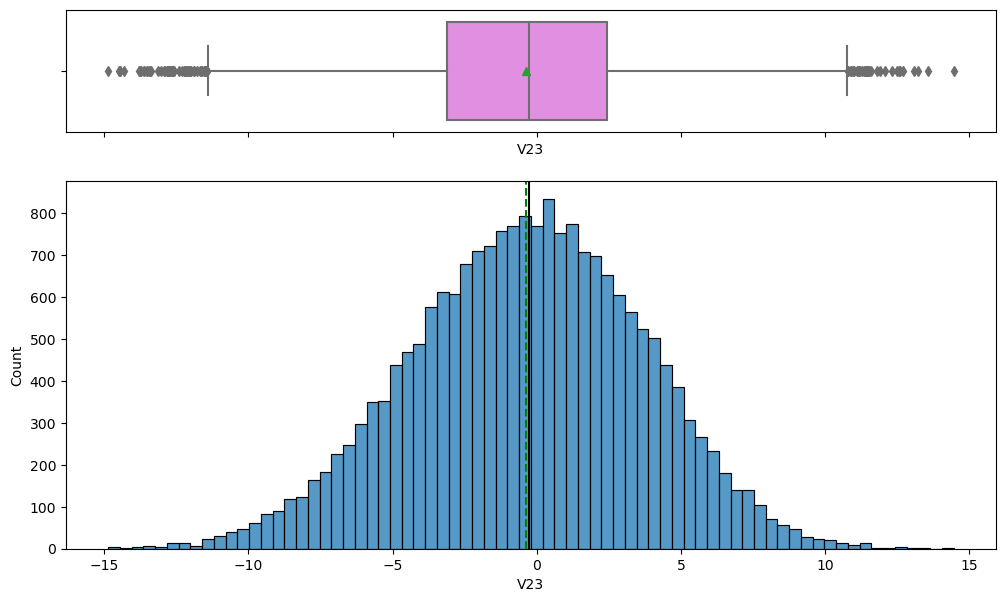

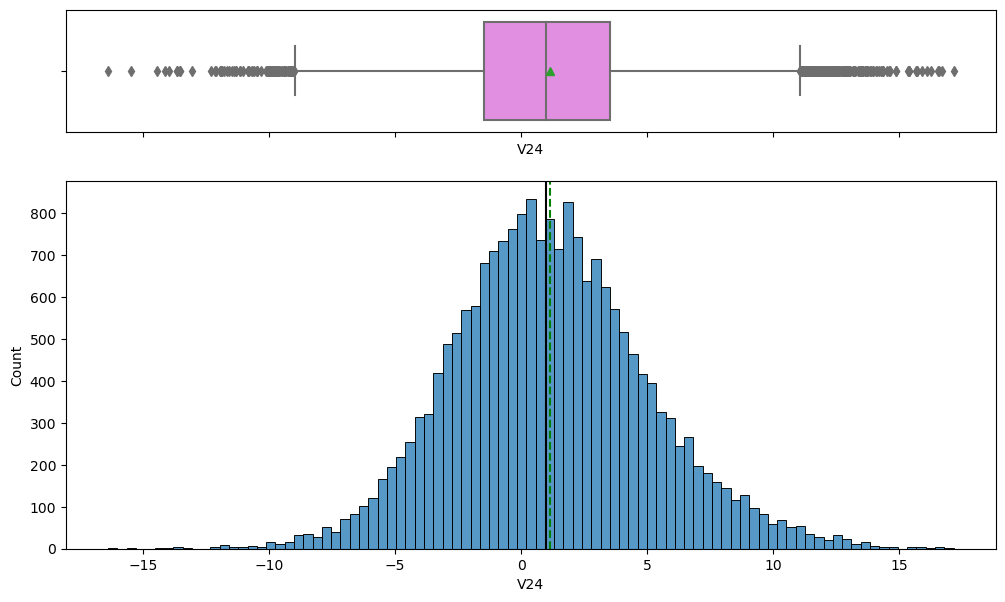

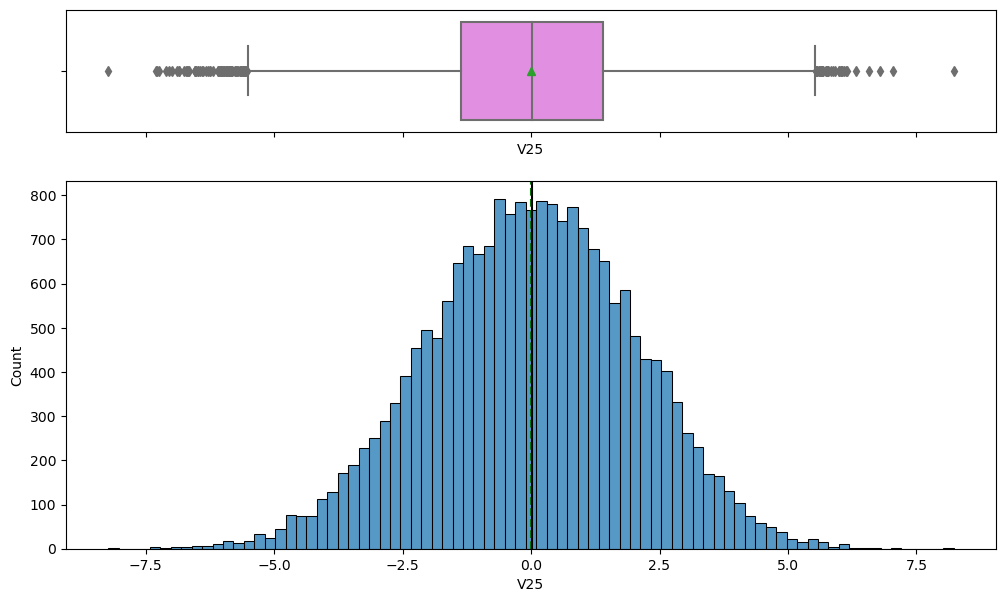

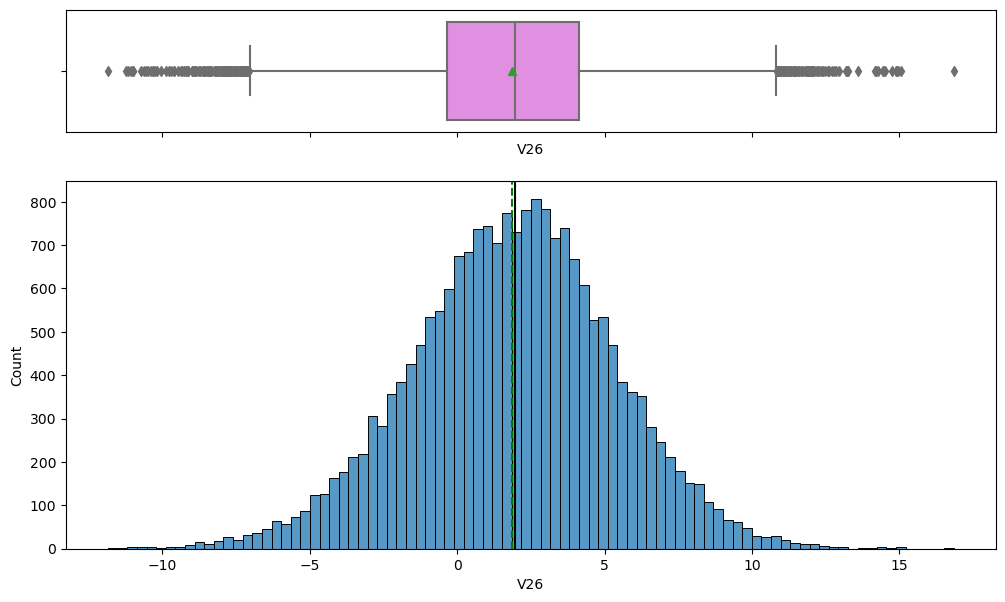

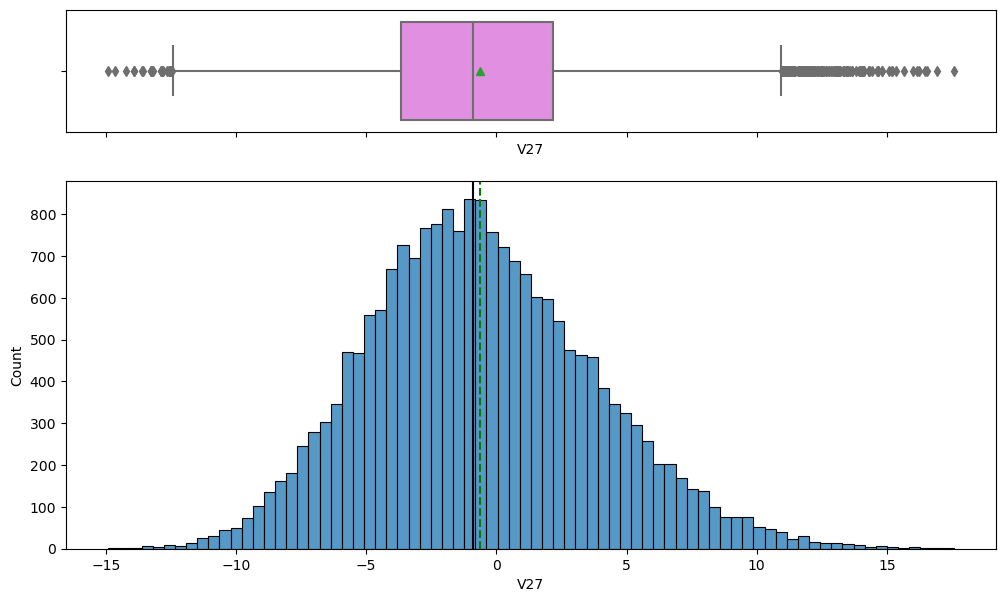

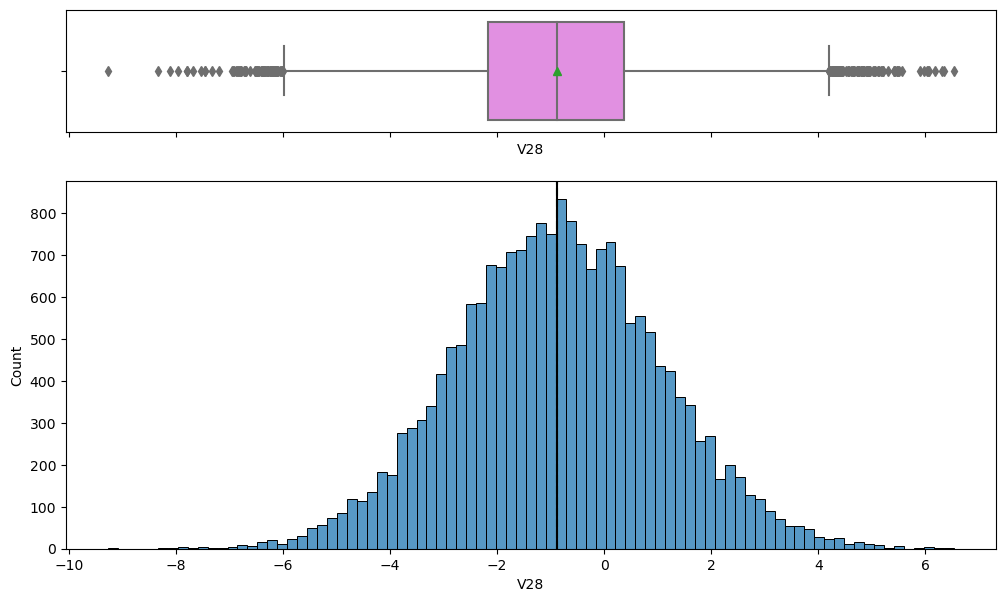

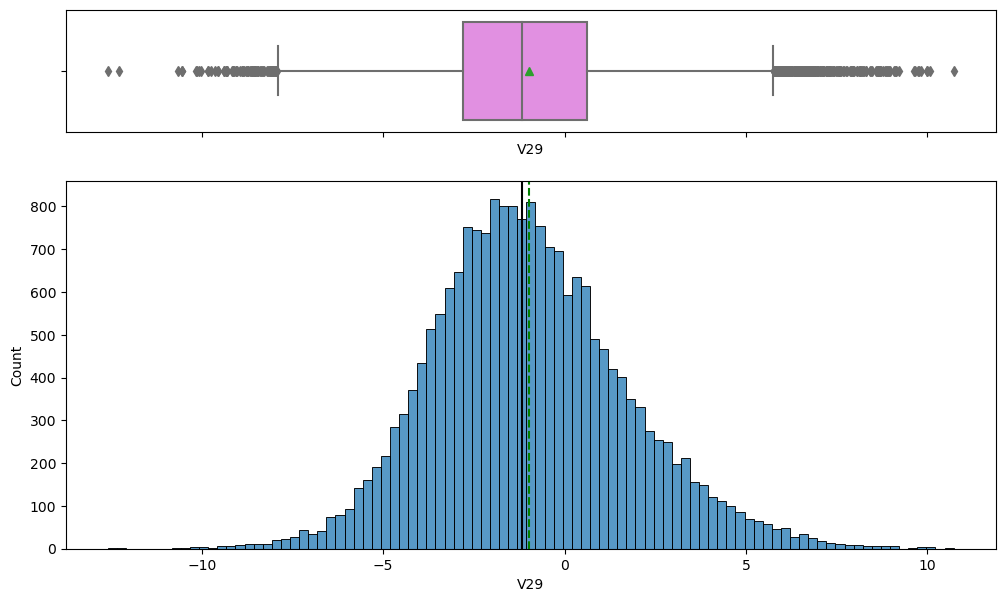

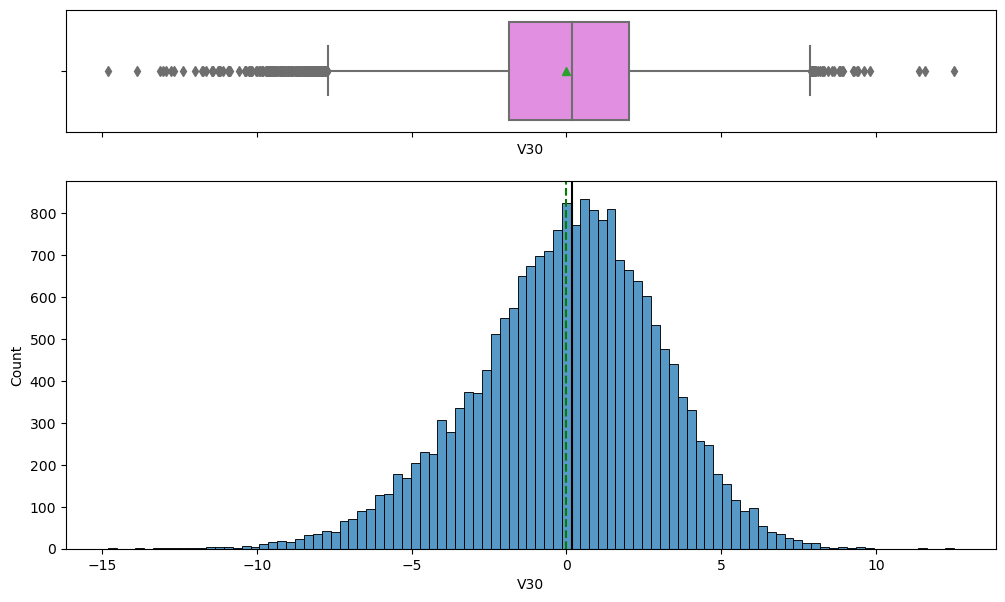

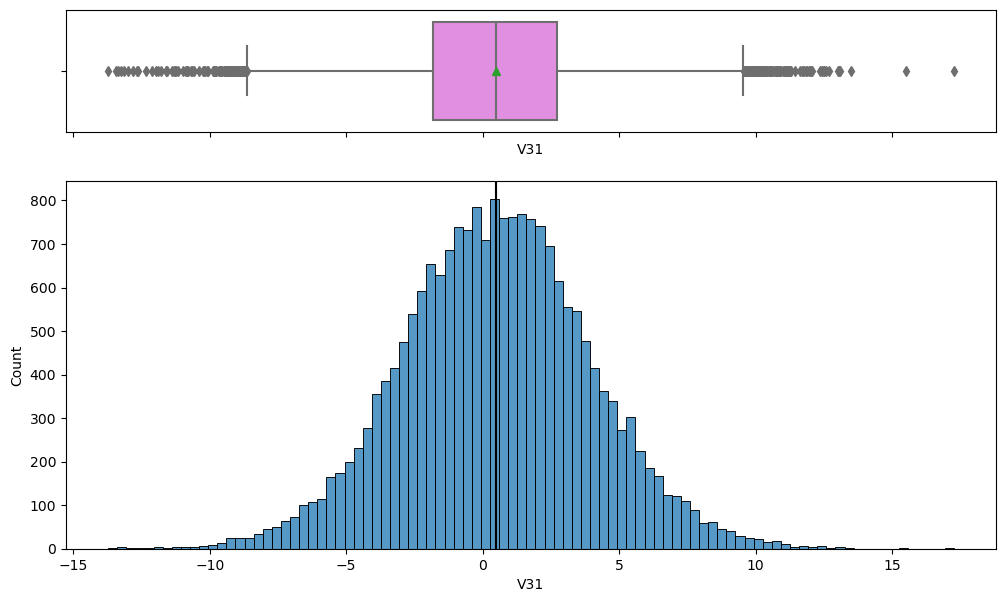

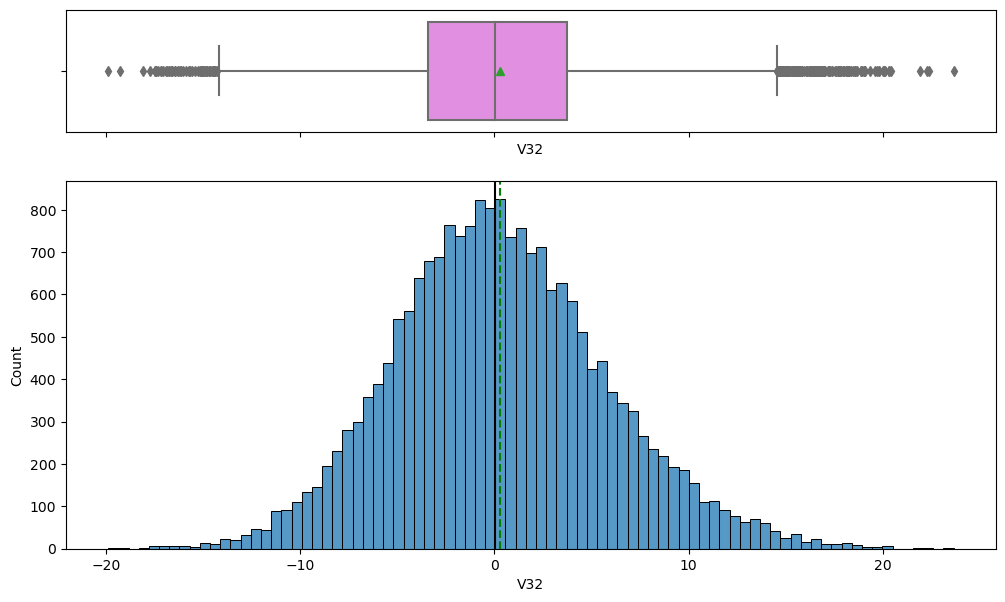

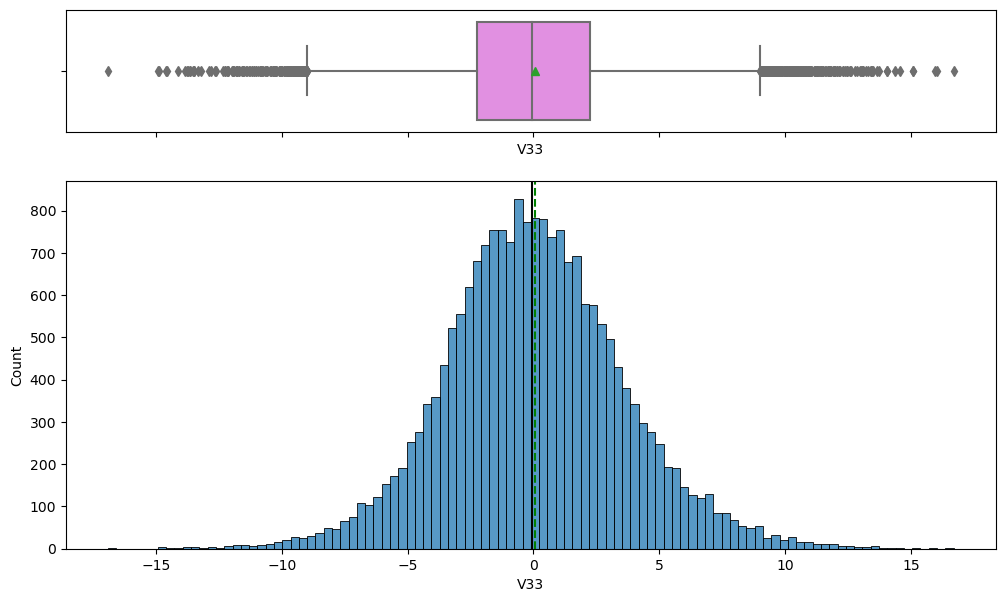

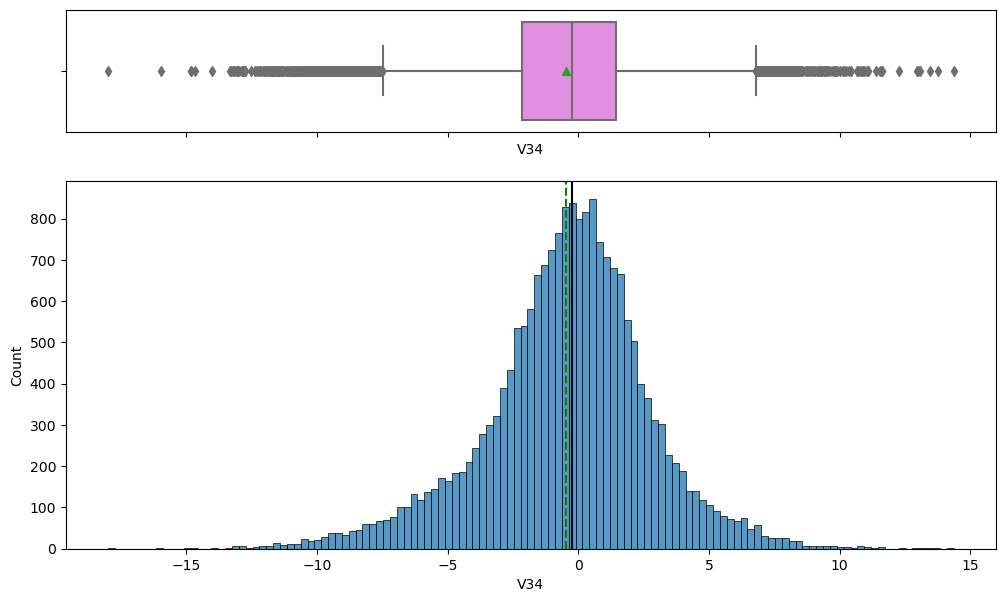

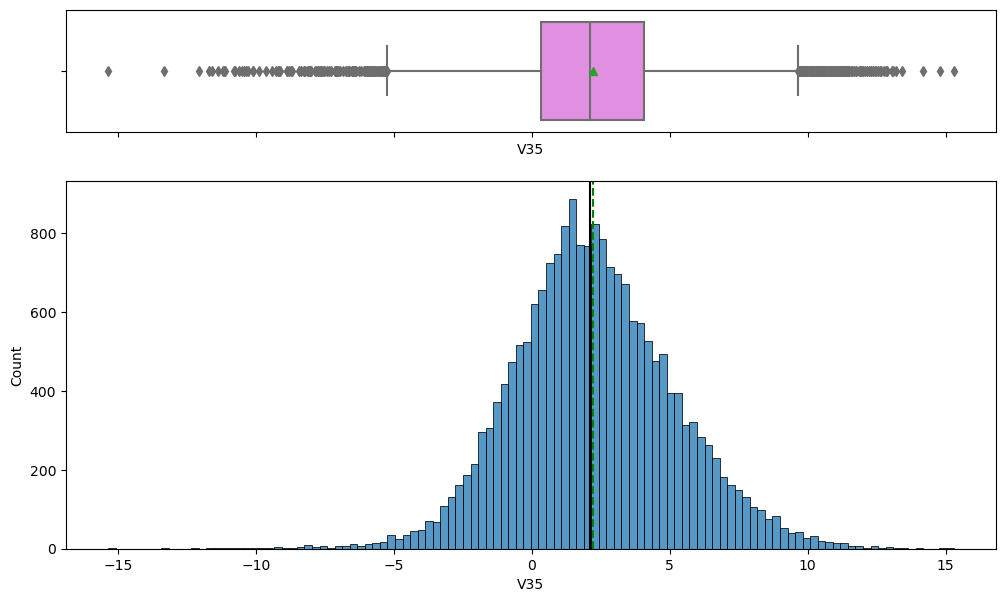

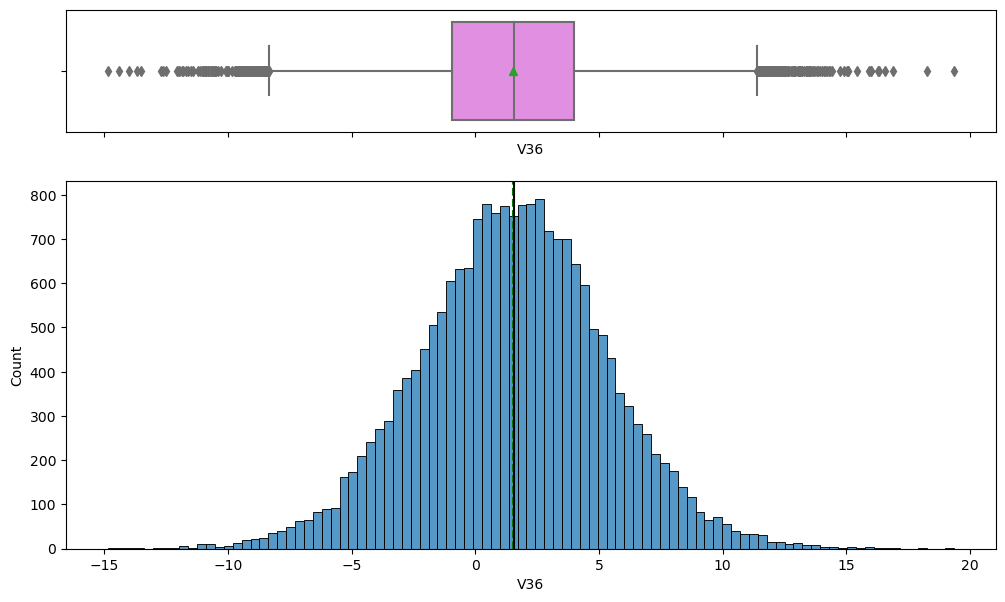

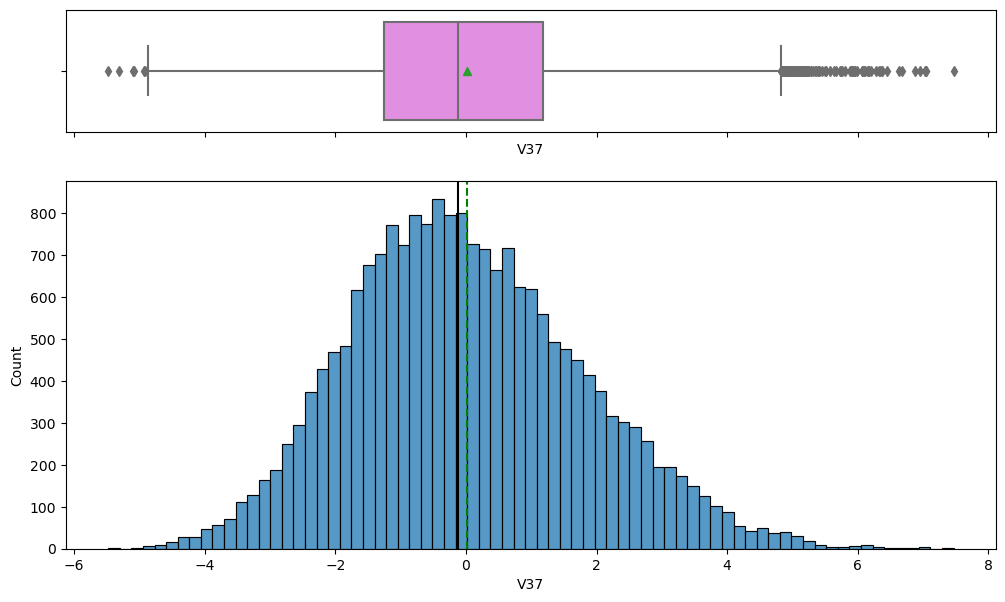

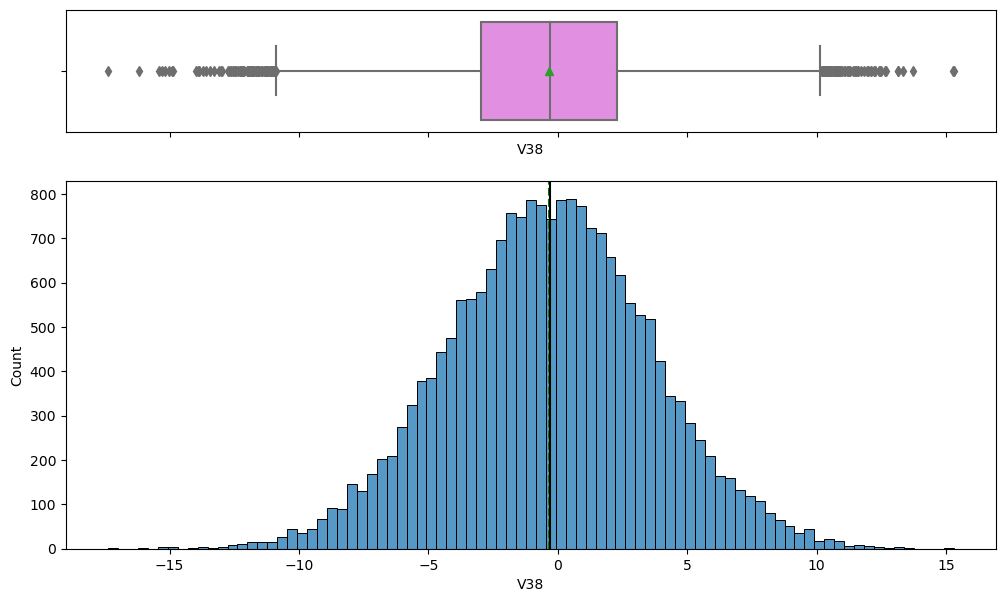

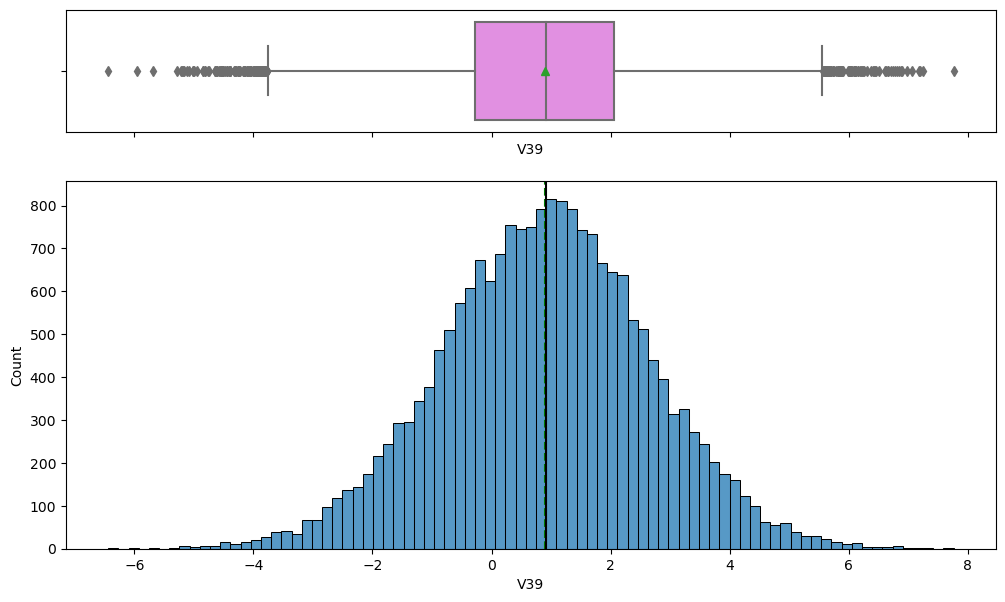

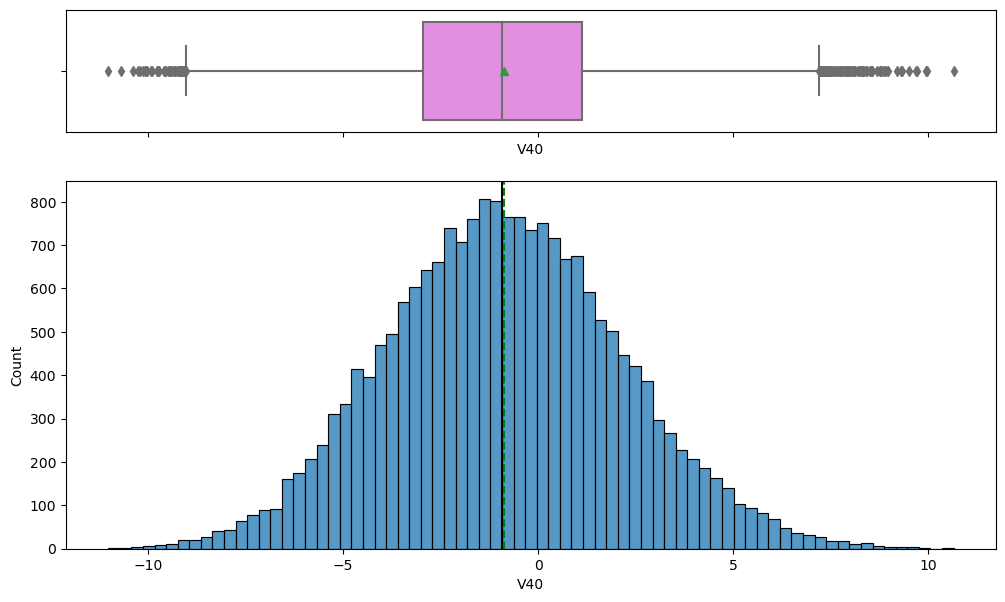

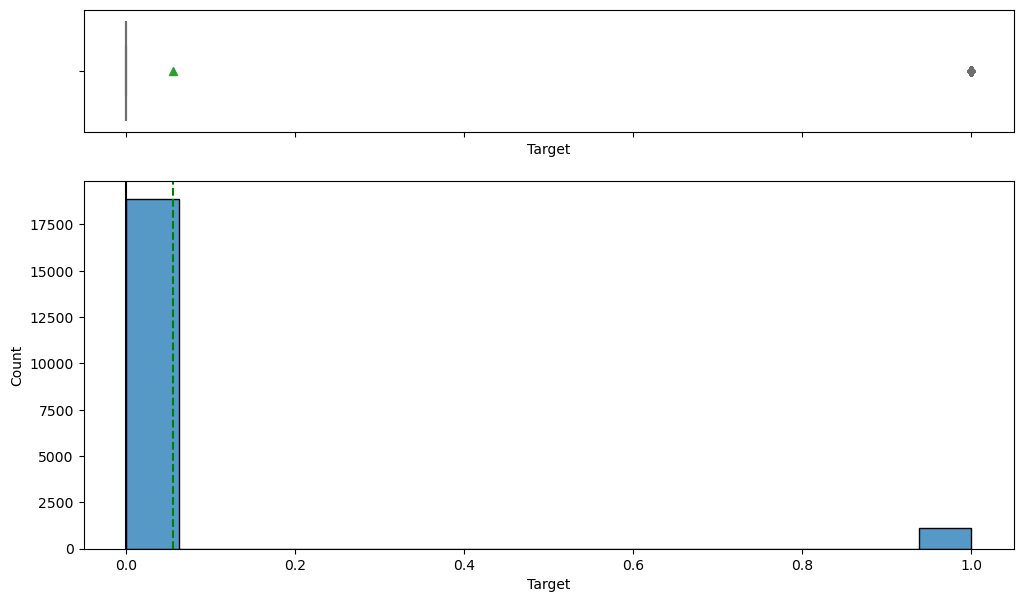

In [15]:
for feature in df.columns:
    histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None)

- All the variables are normally distributed
- This distribution might not be true for original data but since the provided data is ciphered, this kind of trend in distribution is possible - maybe the original data was transformed to normally distributed data.
- The outliers visible through boxplots are not incorrect readings, the values might be like this only.

### Let's look at the values in target variable

In [16]:
df["Target"].value_counts(1)

0   0.945
1   0.056
Name: Target, dtype: float64

In [17]:
df_test["Target"].value_counts(1)

0   0.944
1   0.056
Name: Target, dtype: float64

- The distribution of 0s and 1s is the same in both Train and Test sets.
- 94.5% of the observations are negative and only 5.5% of the observations are a positive representing failure.

## Data Pre-Processing

### Data Preparation for Modeling

In [18]:
# Dividing train data into X and y 
X = data.drop(["Target"], axis=1)
y = data["Target"]

**Since we already have a separate test set, we don't need to divide data into train, valiation and test**


In [19]:
# Splitting data into training and validation set:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

In [20]:
# Checking the number of rows and columns in the X_train data
X_train.shape

(15000, 40)

In [21]:
# Checking the number of rows and columns in the X_val data
X_val.shape

(5000, 40)

In [22]:
# Dividing test data into X_test and y_test
X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

In [23]:
# Checking the number of rows and columns in the X_test data
X_test.shape

(5000, 40)

### Missing value imputation


- There were few missing values in V1 and V2, we will impute them using the median.
- And to avoid data leakage we will impute missing values after splitting train data into train and validation sets.




In [24]:
imputer = SimpleImputer(strategy="median")

In [25]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [26]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

- All the missing values have been imputed

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [27]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
  

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
          },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [28]:
scorer = metrics.make_scorer(metrics.recall_score)

**We are now done with pre-processing and evaluation criterion, so let's start building the model.**

### Model building with original data

In [29]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring = scorer,cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.4927566553639709
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.7956208065796118
dtree: 0.6982829521679532

Validation Performance:

Logistic regression: 0.48201438848920863
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8201438848920863
dtree: 0.7050359712230215


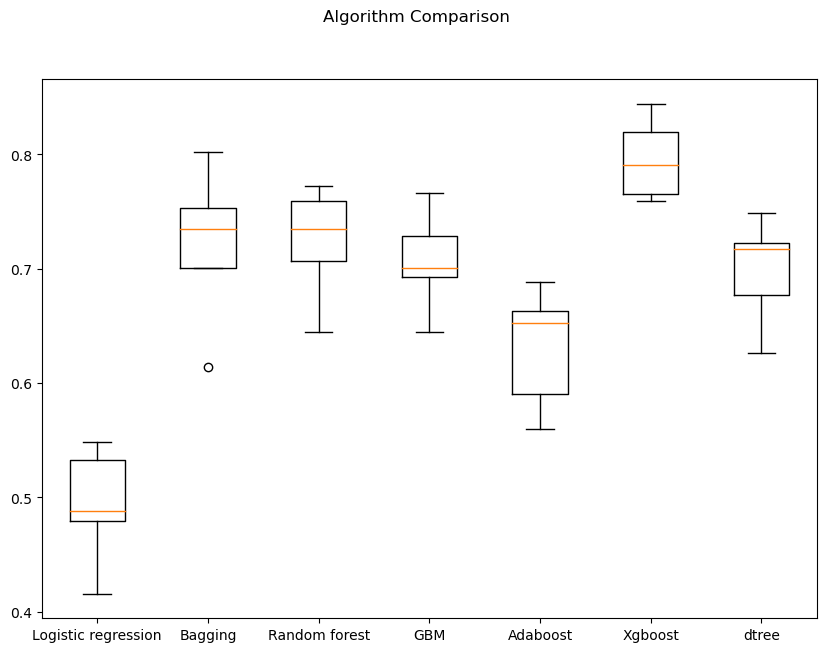

In [30]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- Recall value is highest for Xgboost followed by Bagging Classifier,Random Forest, and Gradient Boosting Classifier.

**We can see the performance of models with original data, let's see if oversampling the data can help us improve the performance.**

### Model Building with oversampled data

In [31]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



In [32]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over,scoring = scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.883963699328486
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
Xgboost: 0.989554053559209
dtree: 0.9720494245534969

Validation Performance:

Logistic regression: 0.8489208633093526
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8561151079136691
Xgboost: 0.8669064748201439
dtree: 0.7769784172661871


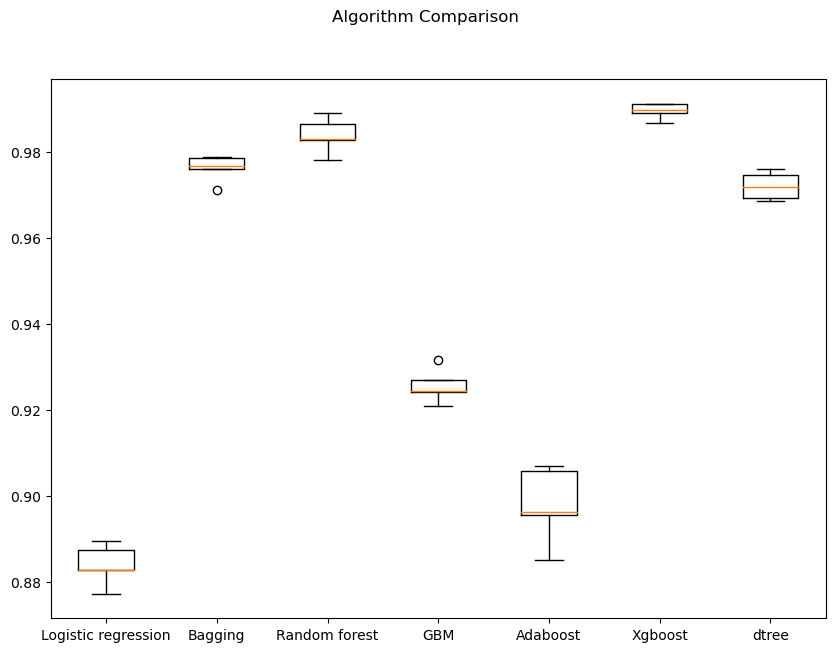

In [33]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- Recall value is highest for Random Forest, Decision tree,and Bagging Classifier, but they are overfitting.

**We can see that oversampling of data helped improve the performance a lot, now let's see how models perform with undersampled data.**

### Model Building with undersampled data

In [34]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



In [35]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss",n_jobs=-1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un,scoring = scorer, cv=kfold,n_jobs =-1
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.8726138085275232
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
GBM: 0.8978572974532861
Adaboost: 0.8666113556020489
Xgboost: 0.9074742082100858
dtree: 0.8617776495202367

Validation Performance:

Logistic regression: 0.8525179856115108
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
GBM: 0.8884892086330936
Adaboost: 0.8489208633093526
Xgboost: 0.9028776978417267
dtree: 0.841726618705036


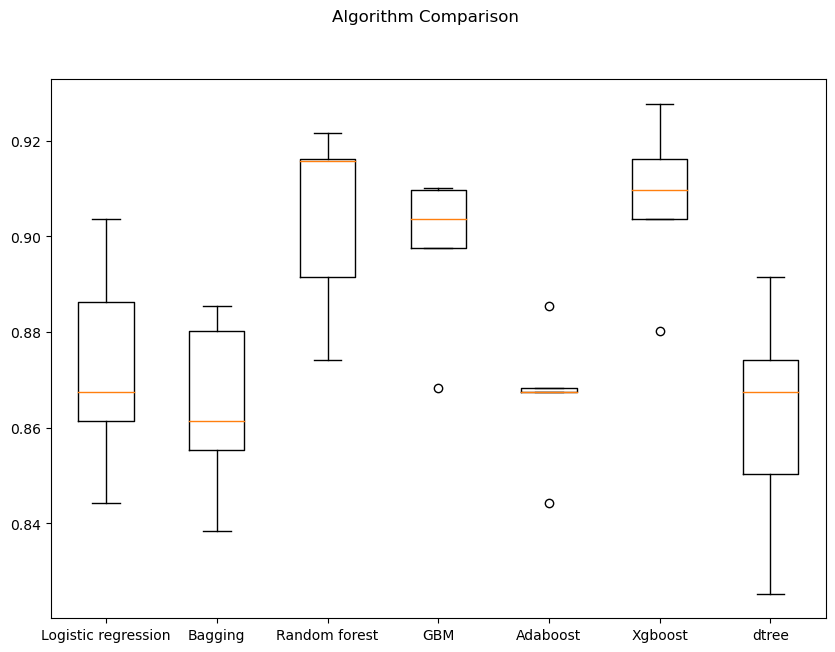

In [36]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- Recall value is highest for Random Forest followed by Xgboost model and Gradient Boosting .


**After looking at performance of all the models, let's decide which models can further improve with hyperparameter tuning**

- Recall value is highest for the following models:
  - Random Forest with undersampled data
  - Gradient Boosting with oversampled data
  - AdaBoost on oversampled data
  - Xgboost on oversampled data
- So, we will tune these 4 models


## Hyperparameter Tuning

### Tuning AdaBoost using oversampled data

In [37]:
%%time 

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over) ## Complete the code to fit the model on over sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.971555946263926:
CPU times: total: 4min 37s
Wall time: 33min 38s


In [38]:
# Creating new pipeline with best parameters
tuned_ada = AdaBoostClassifier(
    n_estimators= 200, learning_rate= 0.2, base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
)

tuned_ada.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [39]:
ada_train_perf = model_performance_classification_sklearn(tuned_ada, X_train_over, y_train_over)
ada_train_perf

Accuracy  Recall  Precision    F1
0     0.992   0.988      0.995 0.992

In [40]:
ada_val_perf = model_performance_classification_sklearn(tuned_ada, X_val, y_val)
ada_val_perf

Accuracy  Recall  Precision    F1
0     0.979   0.853      0.790 0.820

- AdaBoost is slightly overfitting the train data but overall the performance has improved.

### Tuning Random forest using undersampled data

In [41]:
%%time 

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un) ## Complete the code to fit the model on under sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990116153235697:
CPU times: total: 5.11 s
Wall time: 1min 4s


In [42]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(
    max_features="sqrt",
    random_state=1,
    max_samples=0.5,
    n_estimators=300,
    min_samples_leaf=2,
)

tuned_rf2.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300,
                       random_state=1)

In [43]:
rf2_train_perf = model_performance_classification_sklearn(
    tuned_rf2, X_train_un, y_train_un
)
rf2_train_perf

Accuracy  Recall  Precision    F1
0     0.961   0.933      0.989 0.960

In [44]:
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_val, y_val)
rf2_val_perf

Accuracy  Recall  Precision    F1
0     0.938   0.885      0.468 0.612

- Random forest classifier is slightly overfitting the train data but overall the performance has improved.

### Tuning with Gradient boosting with oversampled data

In [45]:
%%time 

# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9724734023671514:
CPU times: total: 27.2 s
Wall time: 11min 40s


In [46]:
# Creating new pipeline with best parameters
tuned_gbm = GradientBoostingClassifier(
    max_features=0.5,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7
)

tuned_gbm.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [47]:
gbm_train_perf = model_performance_classification_sklearn(
    tuned_gbm, X_train_over, y_train_over
)
gbm_train_perf

Accuracy  Recall  Precision    F1
0     0.993   0.993      0.994 0.993

In [48]:
gbm_val_perf = model_performance_classification_sklearn(tuned_gbm, X_val, y_val)
gbm_val_perf

Accuracy  Recall  Precision    F1
0     0.971   0.845      0.693 0.762

- Gradient Boosting is slightly overfitting the train data but overall the performance has improved.

### Tuning XGBoost using oversampled data

In [49]:
%%time 

# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':[150,200,250],'scale_pos_weight':[5,10], 'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)## Complete the code to fit the model on over sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.995765154155294:
CPU times: total: 1min 25s
Wall time: 37min 55s


In [50]:
xgb2 = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.2,
    gamma=0,
)

xgb2.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [51]:
xgb2_train_perf = model_performance_classification_sklearn(
    xgb2, X_train_over, y_train_over
)
xgb2_train_perf

Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000

In [52]:
xgb2_val_perf = model_performance_classification_sklearn(xgb2, X_val, y_val)
xgb2_val_perf

Accuracy  Recall  Precision    F1
0     0.986   0.878      0.878 0.878

- Overfitting has further increased using oversampled data and the model is performing good on train data.

**We have now tuned all the models, let's compare the performance of all tuned models and see which one is the best.**

## Model performance comparison and choosing the final model

In [53]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        gbm_train_perf.T,
        xgb2_train_perf.T,
        ada_train_perf.T,
        rf2_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "XGBoost tuned with oversampled data",
    "AdaBoost tuned with oversampled data",
    "Random forest tuned with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Gradient Boosting tuned with oversampled data  \
Accuracy                                           0.993   
Recall                                             0.993   
Precision                                          0.994   
F1                                                 0.993   

           XGBoost tuned with oversampled data  \
Accuracy                                 1.000   
Recall                                   1.000   
Precision                                1.000   
F1                                       1.000   

           AdaBoost tuned with oversampled data  \
Accuracy                                  0.992   
Recall                                    0.988   
Precision                                 0.995   
F1                                        0.992   

           Random forest tuned with undersampled data  
Accuracy                                        0.961  
Recall                                          0.933  
Precision                                       0.989  
F1                                              0.960

In [54]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        gbm_val_perf.T,
        xgb2_val_perf.T,
        ada_val_perf.T,
        rf2_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "XGBoost tuned with oversampled data",
    "AdaBoost tuned with oversampled data",
    "Random forest tuned with undersampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


Gradient Boosting tuned with oversampled data  \
Accuracy                                           0.971   
Recall                                             0.845   
Precision                                          0.693   
F1                                                 0.762   

           XGBoost tuned with oversampled data  \
Accuracy                                 0.986   
Recall                                   0.878   
Precision                                0.878   
F1                                       0.878   

           AdaBoost tuned with oversampled data  \
Accuracy                                  0.979   
Recall                                    0.853   
Precision                                 0.790   
F1                                        0.820   

           Random forest tuned with undersampled data  
Accuracy                                        0.938  
Recall                                          0.885  
Precision                                       0.468  
F1                                              0.612

- The best validation recall score is 88.5% and obtained for XGBoost tuned with oversampled data and Randomforest with undersampled data.
- But the validation precision is very low at the same time,which will result in increased inspection cost. 
- So, we will choose AdaBoost tuned with oversampled data as the final model.

**Now we have our final model, let's find out how our model is performing on unseen test data**

In [55]:
# Let's check the performance on test set
ada_test = model_performance_classification_sklearn(tuned_ada, X_test, y_test)
ada_test

Accuracy  Recall  Precision    F1
0     0.978   0.844      0.780 0.811


- Let's check feature importance for AdaBoost classifier.

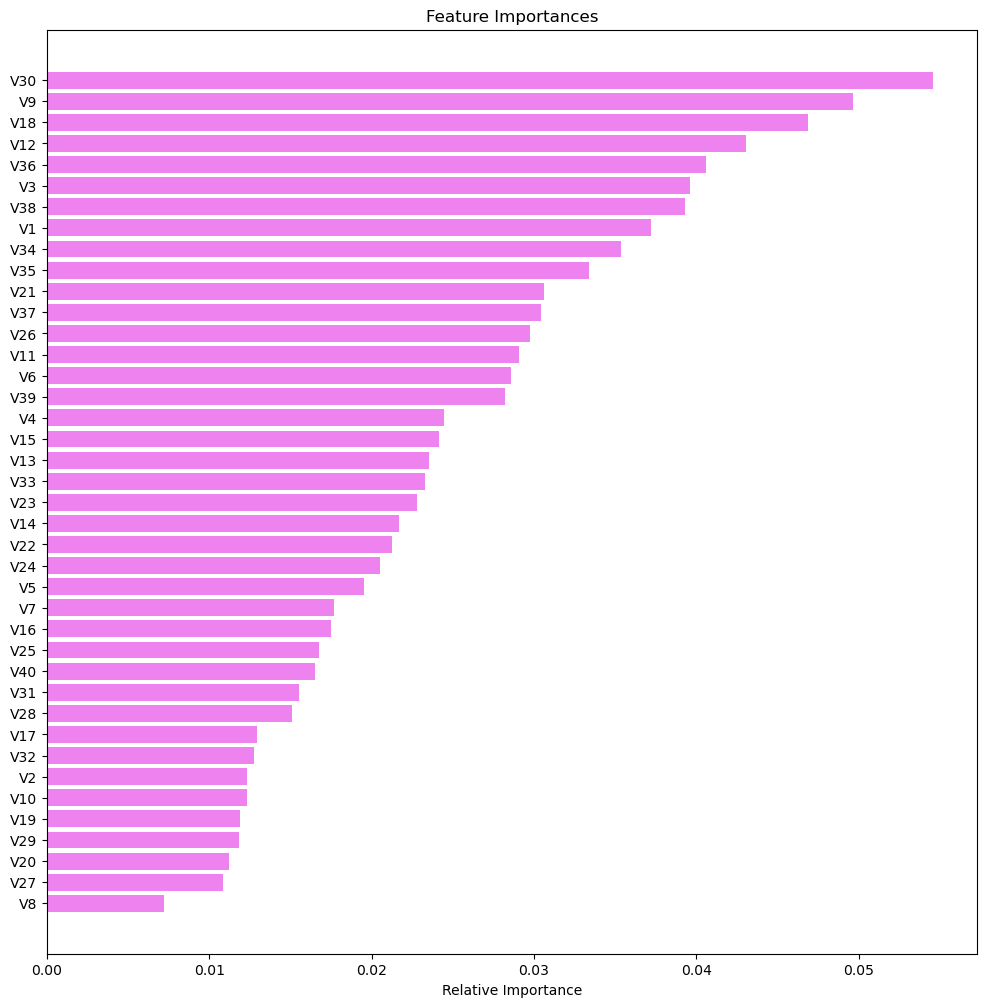

In [56]:
feature_names = X_train.columns
importances = tuned_ada.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- V30 is most important feature followed by V9 and V18.

## Let's use Pipelines to build the final model

- Since we have only one datatype in the data, we don't need to use column transformer here

In [57]:
Pipeline_model = Pipeline(
   steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "AdaBoost Classifier",
             AdaBoostClassifier(
                random_state=1,
                learning_rate=0.2,
                n_estimators=200,
                base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1),
            ),
       ),
    ]
)

In [58]:
# Separating target variable and other variables
X1 = data.drop(columns="Target")
Y1 = data["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test

X_test1 = df_test.drop(["Target"], axis=1)
y_test1 = df_test["Target"]

In [59]:
# We can't oversample data without doing missing value treatment, so let's first treat missing values in train set
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# We don't need to impute missing values in test set as it will be done inside pipeline

In [60]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

In [61]:
Pipeline_model.fit(X_over1, y_over1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('AdaBoost Classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          random_state=1),
                                    learning_rate=0.2, n_estimators=200,
                                    random_state=1))])

In [62]:
# Let's check the performance on test set
Pipeline_model_test = model_performance_classification_sklearn(Pipeline_model, X_test, y_test)
Pipeline_model_test

Accuracy  Recall  Precision    F1
0     0.978   0.851      0.774 0.811

## Business Insights and Conclusions


- The AdaBoost Classifier tuned using oversampled data has the best performance.
- V30, V9 and V18 are the most important features. They can be deciphered to determine and analyze the actual variables to understand their impact on the predictive task at hand.
- This model can be further used to detect if a wind turbine will fail or not and this will help reduce the cost.
- We also saw that there might be few points near around the classification threshold(0.5 by default) which can be further studied by the engineer and a final call could be made.

## Let's do some analysis of False Negatives (Not graded)

In [63]:
# Find out probabilities and predictions on test set
pred = tuned_ada.predict(X_test)
prob = tuned_ada.predict_proba(X_test)

In [64]:
# creating a dataframe for the predicted, original and probabilities predicted by model
result = pd.DataFrame(
    np.transpose([y_test, pred, prob[:, 1]]),
    columns=["Original", "Predicted", "Probability"],
)

In [65]:
# Let's add label of FN, FP, TP, TN based on predicted values


def Label(df):
    if (df["Predicted"] == 0) & (df["Original"] == 0):
        return "TN"

    elif (df["Predicted"] == 1) & (df["Original"] == 1):
        return "TP"

    elif df["Predicted"] > df["Original"]:
        return "FP"

    elif df["Predicted"] < df["Original"]:
        return "FN"

In [66]:
result["Label"] = result.apply(Label, axis=1)

In [67]:
# This is the final dataframe, which we can use to see if some pattern exists
result.head()

Original  Predicted  Probability Label
0     0.000      0.000        0.444    TN
1     0.000      0.000        0.478    TN
2     0.000      0.000        0.447    TN
3     0.000      0.000        0.420    TN
4     0.000      0.000        0.466    TN

In [68]:
# With the threshold being 0.50, there could be some point near to the threshold which could be misclassified by the model
# but they could be later analyzed by the team to decide if we can take a call on those samples

result[(result["Probability"] > 0.45) & (result["Probability"] < 0.5)][
    "Label"
].value_counts()

TN    2399
FN      21
Name: Label, dtype: int64

- If the threshold would have been 0.45 instead of 0.5, we will be able to classify 21 FN as TP and 2399 TN as FP
- Changing the threshold can further help reduce the cost and such a call can be made by looking at probabilities at later stages, as changing the threshold directly might not help always.

## Let's do some EDA for important variables (Not graded)

In [69]:
### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

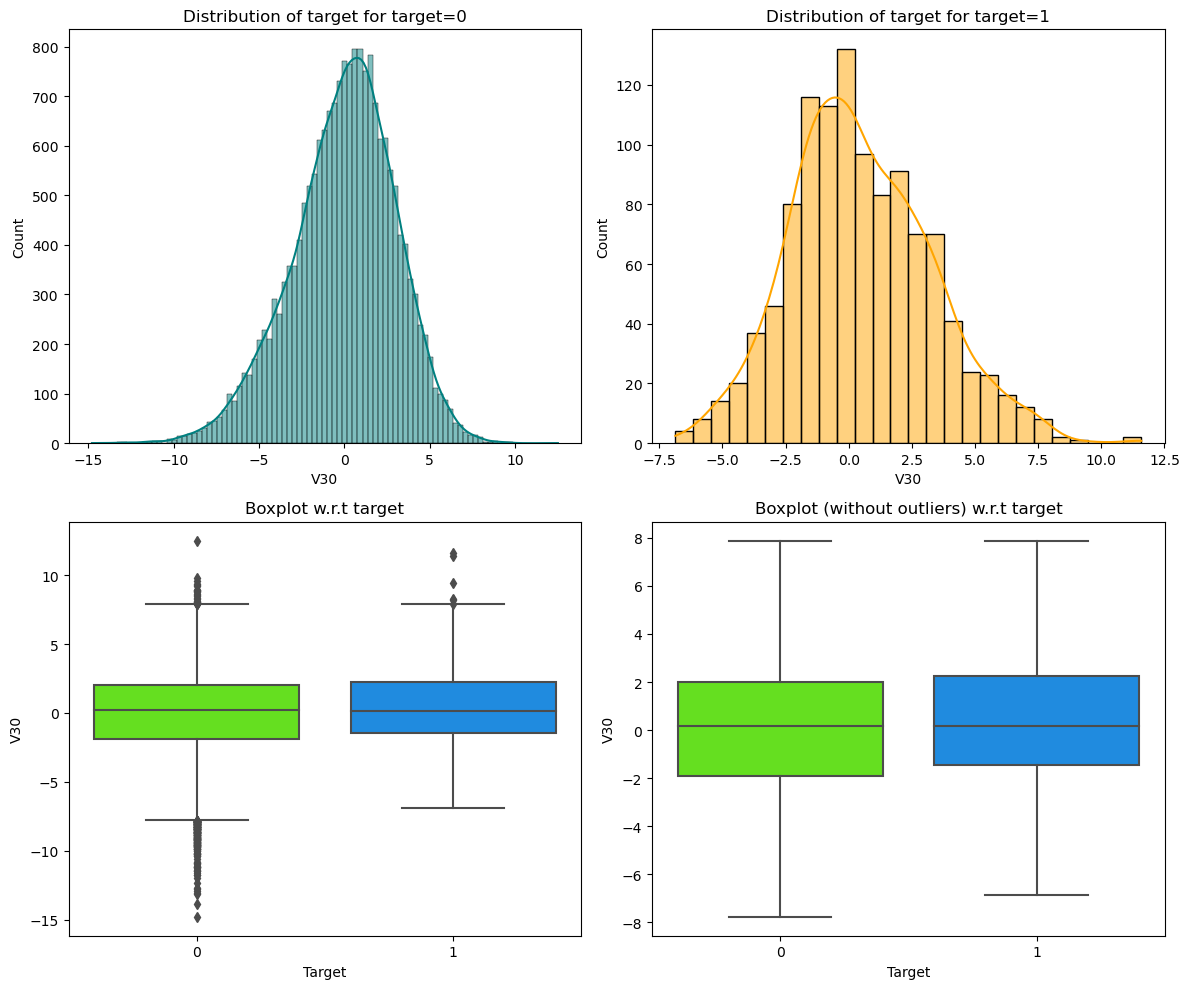

In [70]:
distribution_plot_wrt_target(data, "V30", "Target")

- We can see that the values of V30 for Target = 0 lie even below -8, while this doesn't hold for V30 with Target = 1.
- So, there are some observations that don't have any overlap and make V30 a good predictor.


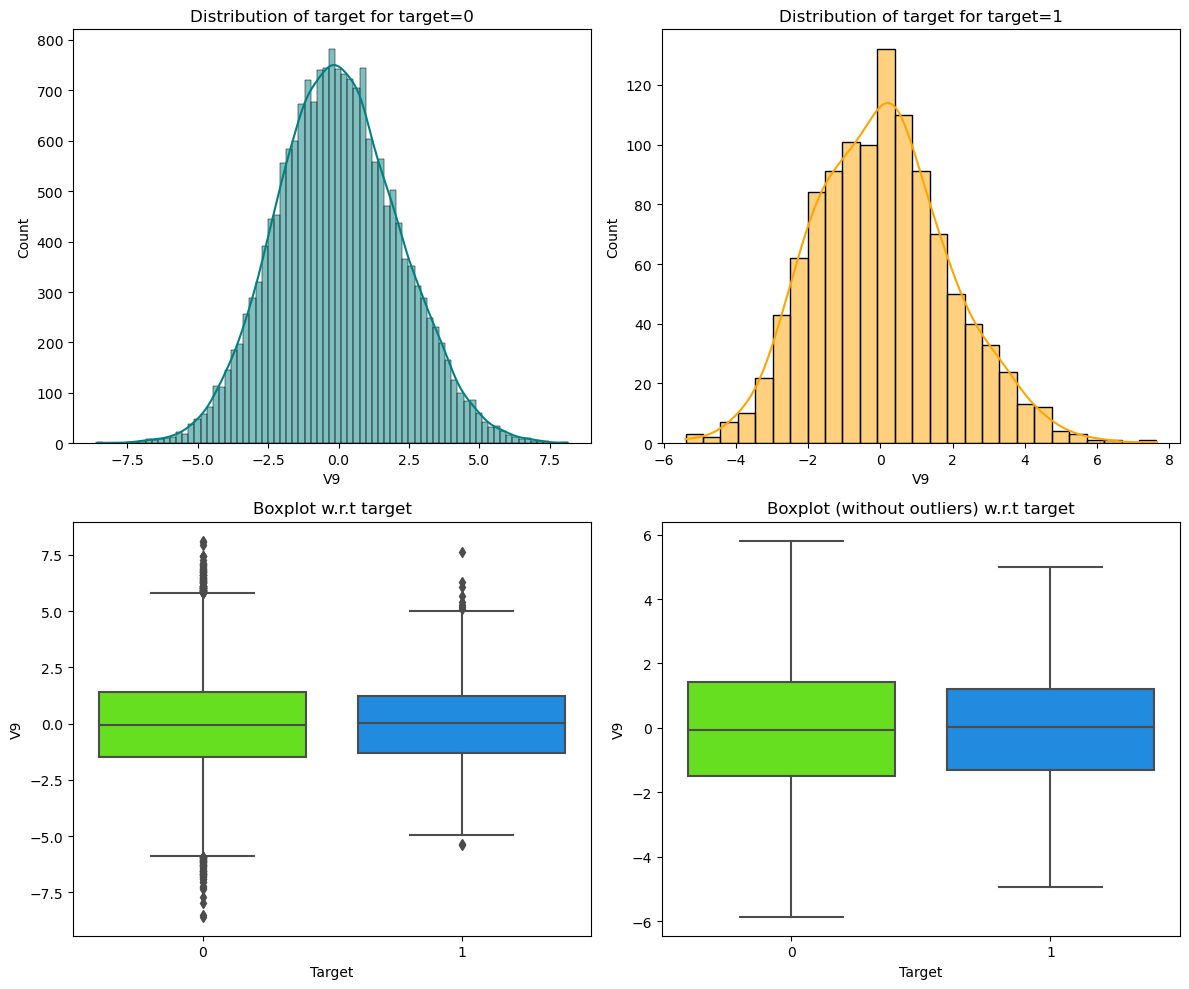

In [71]:
distribution_plot_wrt_target(data, "V9", "Target")

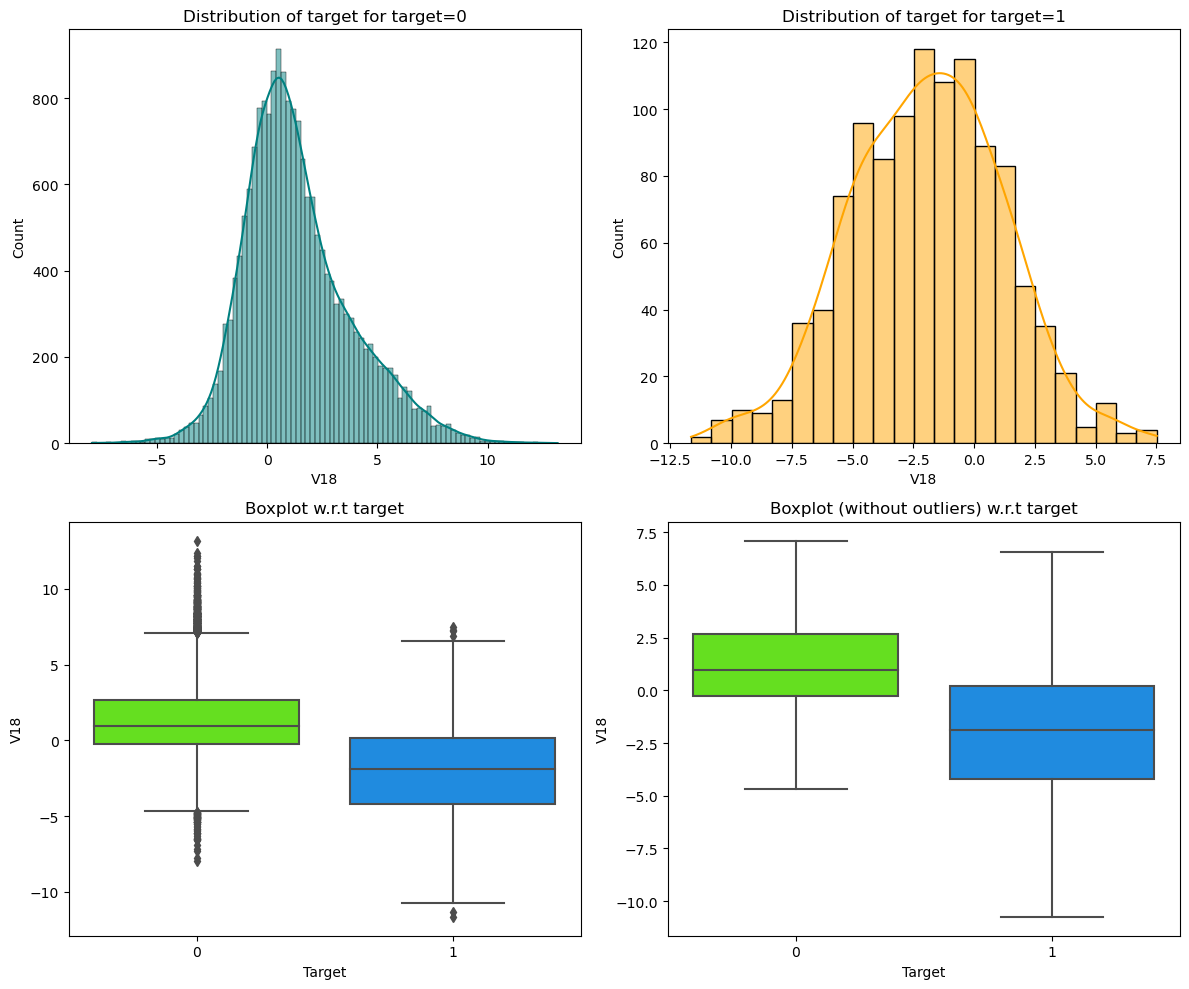

In [72]:
distribution_plot_wrt_target(data, "V18", "Target")

- In V9 and V18, the distribution of data with target = 1 and target = 0 is very same
- Even after complete overlap between the values, these variables are good predictions - The combination of predictors could make a good predictor.

- We can also see that after treating outliers - V9 could become a very good predictor as after treating outliers, there are few non-overlapping observations, but since this might represent the true pattern, hence outlier treatment hasn't been done.